## Demuxing

You could also parallelize it, with different starting points that you put together in the following

see Thorben's thesis:
- 24 replicas from 275 K to 400 K
- 1 micros per replica
- 300 K corresponds to replica 6 (counting from 1)

In [1]:
import numpy as np
import time
import MDAnalysis as mda
from scipy.spatial import distance
import pandas

ModuleNotFoundError: No module named 'MDAnalysis'

In [13]:
x = np.random.rand(2, 10)  # M x N (M observations, N coordinates)
x_new = np.random.rand(2, 10)


In [14]:
from scipy.spatial import distance

In [23]:
f = lambda x1, x2 : len(np.where(np.abs(x1 - x2) < 0.1)[0])

In [24]:
diff = distance.cdist(x, x_new, f)

In [25]:
diff.shape

diff

array([[2., 3.],
       [2., 1.]])

### ...

In [4]:
np.load('1_GITHUB/backbone1_gamma_3J.npy').shape

(1012000, 11)

In [36]:
v = np.array([2.0,3.0])

v = v.astype(int)
#v[1] = +v[1].astype(int)
v
#np.zeros(np.int(v[0]))

array([2, 3])

In [25]:
n_frames = 10000
n_replicas = 24

replica_index=np.zeros(n_frames)
for m in range(np.int(n_frames/n_replicas)):
    for i in range(n_replicas):
        replica_index[n_replicas*m+i]=i
for i in range(np.mod(n_frames,n_replicas)):
    replica_index[n_replicas*(m+1)+i]=i

print(replica_index[:50])

np.random.shuffle(replica_index)
print(replica_index[:50])

[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23.  0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11.
 12. 13. 14. 15. 16. 17. 18. 19. 20. 21. 22. 23.  0.  1.]
[22. 20. 21.  2. 12.  8. 18.  1. 16. 14. 16. 21. 15. 18.  4.  7. 16. 20.
  3. 12. 17.  6. 20. 21. 21. 13.  9. 22. 13. 16.  9.  1. 13.  8. 18. 18.
  7. 14.  1.  7.  2.  2. 19. 14. 22. 23. 19.  4. 12.  7.]


In [7]:
df = pandas.read_csv('demuxing_UCAAUC_saved/demuxed')
len(df)
df

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,0,1,2,3,4,5,6,7,8,10,...,14,15,16,17,18,19,22,20,21,23
1,0,1,2,3,4,5,6,7,8,9,...,15,14,16,18,17,19,22,20,21,23
2,0,2,1,3,4,5,6,7,8,9,...,15,14,18,16,17,19,22,20,21,23
3,0,2,1,3,4,5,6,7,8,10,...,15,14,18,16,17,19,20,22,21,23
4,0,2,1,3,4,5,6,7,8,10,...,14,15,18,16,19,17,20,21,22,23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
969994,0,10,19,17,13,23,22,21,9,12,...,14,1,4,16,5,20,8,2,7,15
969995,10,0,19,17,13,23,22,9,21,12,...,1,14,16,4,5,20,8,7,2,15
969996,0,10,17,19,13,23,22,21,9,12,...,1,14,16,4,8,5,20,7,15,2
969997,0,10,17,13,19,23,21,22,9,6,...,3,16,14,4,20,8,5,7,2,15


In [6]:
# useless
import py3Dmol
from MDAnalysis.analysis.dihedrals import Dihedral as dihedral
import matplotlib.pyplot as plt
from scipy.optimize import linear_sum_assignment
import numba

## Input data
General data for all the tetramers:
- their names (Sequences)
- the n. of subtrajectories
- the n. of replicas (in this case, it should be equal for all the tetramers)

Input data for demuxing:
- path_ref: the path of the reference (topology .pdb), useless if you extract coordinates directly from .xtc
- paths_traj: the paths of the trajectories
- start_frame: skip the first frame, because it is equal to the last of the previous subtraj or because it is the first subtraj and you skipped it
- max_step: useful only if you evaluate the n. of atoms moving less than max_step

In [2]:
Sequence='UCAAUC'
n_replicas=24

curr_dir='/net/sbp/srnas2/tfrahlki/Simulations/%s_TREMD/Production/%s' % (Sequence,Sequence)

n_max_subtraj=310 # 310 for UCAAUC, 100 for UCUCGU (?)

start_frame=1

In [3]:
print('tetramer: ',Sequence)
print(curr_dir)

path_ref=curr_dir+'/reference.pdb'

l=[]

for i in range(2,n_max_subtraj+1):
    s='000%s'%i
    s=s[-4:]
    l.append(s)

paths_traj=[]
paths_traj.append(curr_dir+'/traj_comp%s.xtc') # % NR
for i in range(len(l)):
    paths_traj.append(curr_dir+'/traj_comp%s.part'+l[i]+'.xtc')



tetramer:  UCAAUC
/net/sbp/srnas2/tfrahlki/Simulations/UCAAUC_TREMD/Production/UCAAUC


In [4]:


# max_step=5


# Algorithm
Assumption: thermodynamic limit

input:
- n_replicas
- paths_traj: the paths of the trajectories (with %s for the different replicas)
- start_frame: starting frame for each subtraj (simple case of frames to skip: the i-th of each subtrajectory)
- if_local: if you want to copy subtrajectories in the same folder of your python script, to run faster (?, anyway you can choose only MW atoms, for instance)
- N: every N frames save required time
- userdoc: the folder path where you save output data

algorithm:
- permutations = np.arange(n_replicas) # first frame: 1,2...n_replicas
- for n_sub in range(N_subtraj):
    - if if_local: copy subtraj(n_sub) in your local folder (as .xtc)
    - if n_sub==0: initialize first frame x 
    - for n_frame in range(start_frame+1,len(subtraj)):
        - x_new = new frame 
        - cost = distance.cdist(x,x_new,"sqeuclidean")
        - (rows,cols1)=linear_sum_assignment(diff1) # or equivalently cols1=np.argmin(diff1,axis=1)
        - permutations.append(permutations[-1][cols2])   

Two ways to read coordinates from frames:
- 1st way:
    - univ=mda.Universe(path_ref,paths_traj[0] % NR)
    - univ.trajectory[n_frame]
    - x1=univ.atoms.positions
- 2nd way: (it seems better)
    - xtc_read=mda.coordinates.XTC.XTCReader(paths_traj[0] % NR)
    - x1=+xtc_read[n_frame][:]
    - here x=+xtc_read[:][:] is the array of coordinates (all atoms, all frames)

output:
- demuxed frame indices
- also the time required for each N frames


Main idea of the algorithm: associate the subsequent replicas to those which vary less

diff = distance.cdist(x,x_new,"sqeuclidean")

cols = np.argmin(diff,axis=1)

permutations.append(permutations[-1][cols])

x = np.array(x_new)


In [4]:
paths_traj[304]

'/net/sbp/srnas2/tfrahlki/Simulations/UCAAUC_TREMD/Production/UCAAUC/traj_comp%s.part0305.xtc'

https://docs.mdanalysis.org/1.0.0/documentation_pages/coordinates/XTC.html

In [16]:
paths_traj[304]

s = paths_traj[304] % 23
print(s)


len(mda.coordinates.XTC.XTCReader(s,refresh_offsets=True))

/net/sbp/srnas2/tfrahlki/Simulations/UCAAUC_TREMD/Production/UCAAUC/traj_comp23.part0305.xtc


IndexError: list index out of range

In [8]:
# check length

length = []
for NR in range(n_replicas):
    length.append([])

for s in paths_traj[:2]:
    for NR in range(n_replicas):
        length[NR].append(len(mda.coordinates.XTC.XTCReader(s % NR)))

/u/i/igilardo/.local/lib/python3.6/site-packages/MDAnalysis/coordinates/XDR.py:232: UserWarning: Couldn't save offsets because: [Errno 13] Permission denied: '/net/sbp/srnas2/tfrahlki/Simulations/UCAAUC_TREMD/Production/UCAAUC/.traj_comp0.xtc_offsets.npz'
  warnings.warn("Couldn't save offsets because: {}".format(e))
/u/i/igilardo/.local/lib/python3.6/site-packages/MDAnalysis/coordinates/XDR.py:232: UserWarning: Couldn't save offsets because: [Errno 13] Permission denied: '/net/sbp/srnas2/tfrahlki/Simulations/UCAAUC_TREMD/Production/UCAAUC/.traj_comp1.xtc_offsets.npz'
  warnings.warn("Couldn't save offsets because: {}".format(e))
/u/i/igilardo/.local/lib/python3.6/site-packages/MDAnalysis/coordinates/XDR.py:232: UserWarning: Couldn't save offsets because: [Errno 13] Permission denied: '/net/sbp/srnas2/tfrahlki/Simulations/UCAAUC_TREMD/Production/UCAAUC/.traj_comp2.xtc_offsets.npz'
  warnings.warn("Couldn't save offsets because: {}".format(e))
/u/i/igilardo/.local/lib/python3.6/site-pac

In [9]:
length

[[8001, 8001],
 [8001, 8001],
 [8001, 8001],
 [8001, 8001],
 [8001, 8001],
 [8001, 8001],
 [8001, 8001],
 [8001, 8001],
 [8001, 8001],
 [8001, 8001],
 [8001, 8001],
 [8001, 8001],
 [8001, 8001],
 [8001, 8001],
 [8001, 8001],
 [8001, 8001],
 [8001, 8001],
 [8001, 8001],
 [8001, 8001],
 [8001, 8001],
 [8001, 8001],
 [8001, 8001],
 [8001, 8001],
 [8001, 8001]]

In [15]:
n_subtraj = 304

#NR = 0
for NR in range(n_replicas):
    print(NR)
    print(len(mda.coordinates.XTC.XTCReader(paths_traj[n_subtraj] % NR)))

0
14001
1


/u/i/igilardo/.local/lib/python3.6/site-packages/MDAnalysis/coordinates/XDR.py:232: UserWarning: Couldn't save offsets because: [Errno 13] Permission denied: '/net/sbp/srnas2/tfrahlki/Simulations/UCAAUC_TREMD/Production/UCAAUC/.traj_comp1.part0305.xtc_offsets.npz'
  warnings.warn("Couldn't save offsets because: {}".format(e))


14001
2


/u/i/igilardo/.local/lib/python3.6/site-packages/MDAnalysis/coordinates/XDR.py:232: UserWarning: Couldn't save offsets because: [Errno 13] Permission denied: '/net/sbp/srnas2/tfrahlki/Simulations/UCAAUC_TREMD/Production/UCAAUC/.traj_comp2.part0305.xtc_offsets.npz'
  warnings.warn("Couldn't save offsets because: {}".format(e))


14001
3


/u/i/igilardo/.local/lib/python3.6/site-packages/MDAnalysis/coordinates/XDR.py:232: UserWarning: Couldn't save offsets because: [Errno 13] Permission denied: '/net/sbp/srnas2/tfrahlki/Simulations/UCAAUC_TREMD/Production/UCAAUC/.traj_comp3.part0305.xtc_offsets.npz'
  warnings.warn("Couldn't save offsets because: {}".format(e))


14001
4


/u/i/igilardo/.local/lib/python3.6/site-packages/MDAnalysis/coordinates/XDR.py:232: UserWarning: Couldn't save offsets because: [Errno 13] Permission denied: '/net/sbp/srnas2/tfrahlki/Simulations/UCAAUC_TREMD/Production/UCAAUC/.traj_comp4.part0305.xtc_offsets.npz'
  warnings.warn("Couldn't save offsets because: {}".format(e))


14001
5


/u/i/igilardo/.local/lib/python3.6/site-packages/MDAnalysis/coordinates/XDR.py:232: UserWarning: Couldn't save offsets because: [Errno 13] Permission denied: '/net/sbp/srnas2/tfrahlki/Simulations/UCAAUC_TREMD/Production/UCAAUC/.traj_comp5.part0305.xtc_offsets.npz'
  warnings.warn("Couldn't save offsets because: {}".format(e))


14001
6


/u/i/igilardo/.local/lib/python3.6/site-packages/MDAnalysis/coordinates/XDR.py:232: UserWarning: Couldn't save offsets because: [Errno 13] Permission denied: '/net/sbp/srnas2/tfrahlki/Simulations/UCAAUC_TREMD/Production/UCAAUC/.traj_comp6.part0305.xtc_offsets.npz'
  warnings.warn("Couldn't save offsets because: {}".format(e))


14001
7


/u/i/igilardo/.local/lib/python3.6/site-packages/MDAnalysis/coordinates/XDR.py:232: UserWarning: Couldn't save offsets because: [Errno 13] Permission denied: '/net/sbp/srnas2/tfrahlki/Simulations/UCAAUC_TREMD/Production/UCAAUC/.traj_comp7.part0305.xtc_offsets.npz'
  warnings.warn("Couldn't save offsets because: {}".format(e))


14001
8


/u/i/igilardo/.local/lib/python3.6/site-packages/MDAnalysis/coordinates/XDR.py:232: UserWarning: Couldn't save offsets because: [Errno 13] Permission denied: '/net/sbp/srnas2/tfrahlki/Simulations/UCAAUC_TREMD/Production/UCAAUC/.traj_comp8.part0305.xtc_offsets.npz'
  warnings.warn("Couldn't save offsets because: {}".format(e))


14001
9


/u/i/igilardo/.local/lib/python3.6/site-packages/MDAnalysis/coordinates/XDR.py:232: UserWarning: Couldn't save offsets because: [Errno 13] Permission denied: '/net/sbp/srnas2/tfrahlki/Simulations/UCAAUC_TREMD/Production/UCAAUC/.traj_comp9.part0305.xtc_offsets.npz'
  warnings.warn("Couldn't save offsets because: {}".format(e))


14001
10


/u/i/igilardo/.local/lib/python3.6/site-packages/MDAnalysis/coordinates/XDR.py:232: UserWarning: Couldn't save offsets because: [Errno 13] Permission denied: '/net/sbp/srnas2/tfrahlki/Simulations/UCAAUC_TREMD/Production/UCAAUC/.traj_comp10.part0305.xtc_offsets.npz'
  warnings.warn("Couldn't save offsets because: {}".format(e))


14001
11


/u/i/igilardo/.local/lib/python3.6/site-packages/MDAnalysis/coordinates/XDR.py:232: UserWarning: Couldn't save offsets because: [Errno 13] Permission denied: '/net/sbp/srnas2/tfrahlki/Simulations/UCAAUC_TREMD/Production/UCAAUC/.traj_comp11.part0305.xtc_offsets.npz'
  warnings.warn("Couldn't save offsets because: {}".format(e))


14001
12


/u/i/igilardo/.local/lib/python3.6/site-packages/MDAnalysis/coordinates/XDR.py:232: UserWarning: Couldn't save offsets because: [Errno 13] Permission denied: '/net/sbp/srnas2/tfrahlki/Simulations/UCAAUC_TREMD/Production/UCAAUC/.traj_comp12.part0305.xtc_offsets.npz'
  warnings.warn("Couldn't save offsets because: {}".format(e))


14001
13


/u/i/igilardo/.local/lib/python3.6/site-packages/MDAnalysis/coordinates/XDR.py:232: UserWarning: Couldn't save offsets because: [Errno 13] Permission denied: '/net/sbp/srnas2/tfrahlki/Simulations/UCAAUC_TREMD/Production/UCAAUC/.traj_comp13.part0305.xtc_offsets.npz'
  warnings.warn("Couldn't save offsets because: {}".format(e))


14001
14


/u/i/igilardo/.local/lib/python3.6/site-packages/MDAnalysis/coordinates/XDR.py:232: UserWarning: Couldn't save offsets because: [Errno 13] Permission denied: '/net/sbp/srnas2/tfrahlki/Simulations/UCAAUC_TREMD/Production/UCAAUC/.traj_comp14.part0305.xtc_offsets.npz'
  warnings.warn("Couldn't save offsets because: {}".format(e))


14001
15


/u/i/igilardo/.local/lib/python3.6/site-packages/MDAnalysis/coordinates/XDR.py:232: UserWarning: Couldn't save offsets because: [Errno 13] Permission denied: '/net/sbp/srnas2/tfrahlki/Simulations/UCAAUC_TREMD/Production/UCAAUC/.traj_comp15.part0305.xtc_offsets.npz'
  warnings.warn("Couldn't save offsets because: {}".format(e))


14001
16


/u/i/igilardo/.local/lib/python3.6/site-packages/MDAnalysis/coordinates/XDR.py:232: UserWarning: Couldn't save offsets because: [Errno 13] Permission denied: '/net/sbp/srnas2/tfrahlki/Simulations/UCAAUC_TREMD/Production/UCAAUC/.traj_comp16.part0305.xtc_offsets.npz'
  warnings.warn("Couldn't save offsets because: {}".format(e))


14001
17


/u/i/igilardo/.local/lib/python3.6/site-packages/MDAnalysis/coordinates/XDR.py:232: UserWarning: Couldn't save offsets because: [Errno 13] Permission denied: '/net/sbp/srnas2/tfrahlki/Simulations/UCAAUC_TREMD/Production/UCAAUC/.traj_comp17.part0305.xtc_offsets.npz'
  warnings.warn("Couldn't save offsets because: {}".format(e))


14001
18


/u/i/igilardo/.local/lib/python3.6/site-packages/MDAnalysis/coordinates/XDR.py:232: UserWarning: Couldn't save offsets because: [Errno 13] Permission denied: '/net/sbp/srnas2/tfrahlki/Simulations/UCAAUC_TREMD/Production/UCAAUC/.traj_comp18.part0305.xtc_offsets.npz'
  warnings.warn("Couldn't save offsets because: {}".format(e))


14001
19


/u/i/igilardo/.local/lib/python3.6/site-packages/MDAnalysis/coordinates/XDR.py:232: UserWarning: Couldn't save offsets because: [Errno 13] Permission denied: '/net/sbp/srnas2/tfrahlki/Simulations/UCAAUC_TREMD/Production/UCAAUC/.traj_comp19.part0305.xtc_offsets.npz'
  warnings.warn("Couldn't save offsets because: {}".format(e))


14001
20


/u/i/igilardo/.local/lib/python3.6/site-packages/MDAnalysis/coordinates/XDR.py:232: UserWarning: Couldn't save offsets because: [Errno 13] Permission denied: '/net/sbp/srnas2/tfrahlki/Simulations/UCAAUC_TREMD/Production/UCAAUC/.traj_comp20.part0305.xtc_offsets.npz'
  warnings.warn("Couldn't save offsets because: {}".format(e))


14001
21


/u/i/igilardo/.local/lib/python3.6/site-packages/MDAnalysis/coordinates/XDR.py:232: UserWarning: Couldn't save offsets because: [Errno 13] Permission denied: '/net/sbp/srnas2/tfrahlki/Simulations/UCAAUC_TREMD/Production/UCAAUC/.traj_comp21.part0305.xtc_offsets.npz'
  warnings.warn("Couldn't save offsets because: {}".format(e))


14001
22


/u/i/igilardo/.local/lib/python3.6/site-packages/MDAnalysis/coordinates/XDR.py:232: UserWarning: Couldn't save offsets because: [Errno 13] Permission denied: '/net/sbp/srnas2/tfrahlki/Simulations/UCAAUC_TREMD/Production/UCAAUC/.traj_comp22.part0305.xtc_offsets.npz'
  warnings.warn("Couldn't save offsets because: {}".format(e))


14001
23


IndexError: list index out of range

In [4]:
#@numba.jit
def demuxing(n_replicas,paths_traj,start_frame,userdoc,N=10000): # if_local
    permutations=[]
    times=[]
    permutations.append(np.arange(n_replicas))

    start=time.time()

    for n_subtraj in range(len(paths_traj)):
        
        xtc_read=[] # xtc_read[NR][n_frame][:]
        for NR in range(n_replicas):
            xtc_read.append(mda.coordinates.XTC.XTCReader(paths_traj[n_subtraj] % NR))
                
        n_frame0=start_frame
        if n_subtraj==0:
            x=[]
            for NR in range(n_replicas):
                x.append(xtc_read[NR][start_frame][:].flatten())
            x=np.array(x)
            n_frame0=start_frame+1 # if already initialised, start from next frame
        
        len_subtraj=len(xtc_read[0])
        for n_frame in range(n_frame0,len_subtraj):
            x_new=[]
            for NR in range(n_replicas):
                x_new.append(xtc_read[NR][n_frame][:].flatten())


            diff = distance.cdist(x,x_new,"sqeuclidean")
            #print('differences: ',diff/1e7)

            x=np.array(x_new)
            #(rows,cols)=linear_sum_assignment(diff)
            # or equivalently:
            cols=np.argmin(diff,axis=1)

            permutations.append(permutations[-1][cols])

            if (n_frame%N)==0:
                times.append(time.time()-start)
                print('n frames: ',n_frame)

        np.savetxt(userdoc+'/demuxed',permutations,fmt='%d',delimiter=',')
        np.savetxt(userdoc+'/time',times,delimiter=',')
        np.savetxt(userdoc+'/n_subtraj',n_subtraj,fmt='%d')
        print(n_subtraj)


    #return permutations, times

### do demux

In [5]:
import os
from pathlib import Path

#userdoc = os.path.join(os.path.expanduser("~"),'2_tetramers/demuxing')
userdoc='demuxing_trial'
Path(userdoc).mkdir(parents=True, exist_ok=True)

permutations, times = demuxing(n_replicas,paths_traj,start_frame,userdoc,N=1000)

/u/i/igilardo/.local/lib/python3.6/site-packages/MDAnalysis/coordinates/XDR.py:232: UserWarning: Couldn't save offsets because: [Errno 13] Permission denied: '/net/sbp/srnas2/tfrahlki/Simulations/UCAAUC_TREMD/Production/UCAAUC/.traj_comp0.xtc_offsets.npz'
  warnings.warn("Couldn't save offsets because: {}".format(e))
/u/i/igilardo/.local/lib/python3.6/site-packages/MDAnalysis/coordinates/XDR.py:232: UserWarning: Couldn't save offsets because: [Errno 13] Permission denied: '/net/sbp/srnas2/tfrahlki/Simulations/UCAAUC_TREMD/Production/UCAAUC/.traj_comp1.xtc_offsets.npz'
  warnings.warn("Couldn't save offsets because: {}".format(e))
/u/i/igilardo/.local/lib/python3.6/site-packages/MDAnalysis/coordinates/XDR.py:232: UserWarning: Couldn't save offsets because: [Errno 13] Permission denied: '/net/sbp/srnas2/tfrahlki/Simulations/UCAAUC_TREMD/Production/UCAAUC/.traj_comp2.xtc_offsets.npz'
  warnings.warn("Couldn't save offsets because: {}".format(e))
/u/i/igilardo/.local/lib/python3.6/site-pac

n frames:  1000
n frames:  2000
n frames:  3000
n frames:  4000
n frames:  5000
n frames:  6000
n frames:  7000
n frames:  8000
0


/u/i/igilardo/.local/lib/python3.6/site-packages/MDAnalysis/coordinates/XDR.py:232: UserWarning: Couldn't save offsets because: [Errno 13] Permission denied: '/net/sbp/srnas2/tfrahlki/Simulations/UCAAUC_TREMD/Production/UCAAUC/.traj_comp0.part0002.xtc_offsets.npz'
  warnings.warn("Couldn't save offsets because: {}".format(e))
/u/i/igilardo/.local/lib/python3.6/site-packages/MDAnalysis/coordinates/XDR.py:232: UserWarning: Couldn't save offsets because: [Errno 13] Permission denied: '/net/sbp/srnas2/tfrahlki/Simulations/UCAAUC_TREMD/Production/UCAAUC/.traj_comp1.part0002.xtc_offsets.npz'
  warnings.warn("Couldn't save offsets because: {}".format(e))
/u/i/igilardo/.local/lib/python3.6/site-packages/MDAnalysis/coordinates/XDR.py:232: UserWarning: Couldn't save offsets because: [Errno 13] Permission denied: '/net/sbp/srnas2/tfrahlki/Simulations/UCAAUC_TREMD/Production/UCAAUC/.traj_comp2.part0002.xtc_offsets.npz'
  warnings.warn("Couldn't save offsets because: {}".format(e))
/u/i/igilardo/.l

n frames:  1000
n frames:  2000
n frames:  3000
n frames:  4000
n frames:  5000
n frames:  6000
n frames:  7000
n frames:  8000
1


/u/i/igilardo/.local/lib/python3.6/site-packages/MDAnalysis/coordinates/XDR.py:232: UserWarning: Couldn't save offsets because: [Errno 13] Permission denied: '/net/sbp/srnas2/tfrahlki/Simulations/UCAAUC_TREMD/Production/UCAAUC/.traj_comp0.part0003.xtc_offsets.npz'
  warnings.warn("Couldn't save offsets because: {}".format(e))
/u/i/igilardo/.local/lib/python3.6/site-packages/MDAnalysis/coordinates/XDR.py:232: UserWarning: Couldn't save offsets because: [Errno 13] Permission denied: '/net/sbp/srnas2/tfrahlki/Simulations/UCAAUC_TREMD/Production/UCAAUC/.traj_comp1.part0003.xtc_offsets.npz'
  warnings.warn("Couldn't save offsets because: {}".format(e))
/u/i/igilardo/.local/lib/python3.6/site-packages/MDAnalysis/coordinates/XDR.py:232: UserWarning: Couldn't save offsets because: [Errno 13] Permission denied: '/net/sbp/srnas2/tfrahlki/Simulations/UCAAUC_TREMD/Production/UCAAUC/.traj_comp2.part0003.xtc_offsets.npz'
  warnings.warn("Couldn't save offsets because: {}".format(e))
/u/i/igilardo/.l

n frames:  1000
n frames:  2000
n frames:  3000
n frames:  4000
n frames:  5000
n frames:  6000
n frames:  7000
n frames:  8000
2


/u/i/igilardo/.local/lib/python3.6/site-packages/MDAnalysis/coordinates/XDR.py:232: UserWarning: Couldn't save offsets because: [Errno 13] Permission denied: '/net/sbp/srnas2/tfrahlki/Simulations/UCAAUC_TREMD/Production/UCAAUC/.traj_comp0.part0004.xtc_offsets.npz'
  warnings.warn("Couldn't save offsets because: {}".format(e))
/u/i/igilardo/.local/lib/python3.6/site-packages/MDAnalysis/coordinates/XDR.py:232: UserWarning: Couldn't save offsets because: [Errno 13] Permission denied: '/net/sbp/srnas2/tfrahlki/Simulations/UCAAUC_TREMD/Production/UCAAUC/.traj_comp1.part0004.xtc_offsets.npz'
  warnings.warn("Couldn't save offsets because: {}".format(e))
/u/i/igilardo/.local/lib/python3.6/site-packages/MDAnalysis/coordinates/XDR.py:232: UserWarning: Couldn't save offsets because: [Errno 13] Permission denied: '/net/sbp/srnas2/tfrahlki/Simulations/UCAAUC_TREMD/Production/UCAAUC/.traj_comp2.part0004.xtc_offsets.npz'
  warnings.warn("Couldn't save offsets because: {}".format(e))
/u/i/igilardo/.l

n frames:  1000
n frames:  2000
n frames:  3000
n frames:  4000
n frames:  5000
n frames:  6000
n frames:  7000
n frames:  8000
3


/u/i/igilardo/.local/lib/python3.6/site-packages/MDAnalysis/coordinates/XDR.py:232: UserWarning: Couldn't save offsets because: [Errno 13] Permission denied: '/net/sbp/srnas2/tfrahlki/Simulations/UCAAUC_TREMD/Production/UCAAUC/.traj_comp0.part0005.xtc_offsets.npz'
  warnings.warn("Couldn't save offsets because: {}".format(e))
/u/i/igilardo/.local/lib/python3.6/site-packages/MDAnalysis/coordinates/XDR.py:232: UserWarning: Couldn't save offsets because: [Errno 13] Permission denied: '/net/sbp/srnas2/tfrahlki/Simulations/UCAAUC_TREMD/Production/UCAAUC/.traj_comp1.part0005.xtc_offsets.npz'
  warnings.warn("Couldn't save offsets because: {}".format(e))
/u/i/igilardo/.local/lib/python3.6/site-packages/MDAnalysis/coordinates/XDR.py:232: UserWarning: Couldn't save offsets because: [Errno 13] Permission denied: '/net/sbp/srnas2/tfrahlki/Simulations/UCAAUC_TREMD/Production/UCAAUC/.traj_comp2.part0005.xtc_offsets.npz'
  warnings.warn("Couldn't save offsets because: {}".format(e))
/u/i/igilardo/.l

n frames:  1000
n frames:  2000
n frames:  3000
n frames:  4000
n frames:  5000
n frames:  6000
n frames:  7000
n frames:  8000
4


/u/i/igilardo/.local/lib/python3.6/site-packages/MDAnalysis/coordinates/XDR.py:232: UserWarning: Couldn't save offsets because: [Errno 13] Permission denied: '/net/sbp/srnas2/tfrahlki/Simulations/UCAAUC_TREMD/Production/UCAAUC/.traj_comp0.part0006.xtc_offsets.npz'
  warnings.warn("Couldn't save offsets because: {}".format(e))
/u/i/igilardo/.local/lib/python3.6/site-packages/MDAnalysis/coordinates/XDR.py:232: UserWarning: Couldn't save offsets because: [Errno 13] Permission denied: '/net/sbp/srnas2/tfrahlki/Simulations/UCAAUC_TREMD/Production/UCAAUC/.traj_comp1.part0006.xtc_offsets.npz'
  warnings.warn("Couldn't save offsets because: {}".format(e))
/u/i/igilardo/.local/lib/python3.6/site-packages/MDAnalysis/coordinates/XDR.py:232: UserWarning: Couldn't save offsets because: [Errno 13] Permission denied: '/net/sbp/srnas2/tfrahlki/Simulations/UCAAUC_TREMD/Production/UCAAUC/.traj_comp2.part0006.xtc_offsets.npz'
  warnings.warn("Couldn't save offsets because: {}".format(e))
/u/i/igilardo/.l

n frames:  1000
n frames:  2000
n frames:  3000
n frames:  4000
n frames:  5000
n frames:  6000
n frames:  7000
n frames:  8000
5


/u/i/igilardo/.local/lib/python3.6/site-packages/MDAnalysis/coordinates/XDR.py:232: UserWarning: Couldn't save offsets because: [Errno 13] Permission denied: '/net/sbp/srnas2/tfrahlki/Simulations/UCAAUC_TREMD/Production/UCAAUC/.traj_comp0.part0007.xtc_offsets.npz'
  warnings.warn("Couldn't save offsets because: {}".format(e))
/u/i/igilardo/.local/lib/python3.6/site-packages/MDAnalysis/coordinates/XDR.py:232: UserWarning: Couldn't save offsets because: [Errno 13] Permission denied: '/net/sbp/srnas2/tfrahlki/Simulations/UCAAUC_TREMD/Production/UCAAUC/.traj_comp1.part0007.xtc_offsets.npz'
  warnings.warn("Couldn't save offsets because: {}".format(e))
/u/i/igilardo/.local/lib/python3.6/site-packages/MDAnalysis/coordinates/XDR.py:232: UserWarning: Couldn't save offsets because: [Errno 13] Permission denied: '/net/sbp/srnas2/tfrahlki/Simulations/UCAAUC_TREMD/Production/UCAAUC/.traj_comp2.part0007.xtc_offsets.npz'
  warnings.warn("Couldn't save offsets because: {}".format(e))
/u/i/igilardo/.l

n frames:  1000
n frames:  2000
n frames:  3000
n frames:  4000
n frames:  5000
n frames:  6000
n frames:  7000
n frames:  8000
6


/u/i/igilardo/.local/lib/python3.6/site-packages/MDAnalysis/coordinates/XDR.py:232: UserWarning: Couldn't save offsets because: [Errno 13] Permission denied: '/net/sbp/srnas2/tfrahlki/Simulations/UCAAUC_TREMD/Production/UCAAUC/.traj_comp0.part0008.xtc_offsets.npz'
  warnings.warn("Couldn't save offsets because: {}".format(e))
/u/i/igilardo/.local/lib/python3.6/site-packages/MDAnalysis/coordinates/XDR.py:232: UserWarning: Couldn't save offsets because: [Errno 13] Permission denied: '/net/sbp/srnas2/tfrahlki/Simulations/UCAAUC_TREMD/Production/UCAAUC/.traj_comp1.part0008.xtc_offsets.npz'
  warnings.warn("Couldn't save offsets because: {}".format(e))
/u/i/igilardo/.local/lib/python3.6/site-packages/MDAnalysis/coordinates/XDR.py:232: UserWarning: Couldn't save offsets because: [Errno 13] Permission denied: '/net/sbp/srnas2/tfrahlki/Simulations/UCAAUC_TREMD/Production/UCAAUC/.traj_comp2.part0008.xtc_offsets.npz'
  warnings.warn("Couldn't save offsets because: {}".format(e))
/u/i/igilardo/.l

n frames:  1000
n frames:  2000
n frames:  3000
n frames:  4000
n frames:  5000
n frames:  6000
n frames:  7000
n frames:  8000
7


/u/i/igilardo/.local/lib/python3.6/site-packages/MDAnalysis/coordinates/XDR.py:232: UserWarning: Couldn't save offsets because: [Errno 13] Permission denied: '/net/sbp/srnas2/tfrahlki/Simulations/UCAAUC_TREMD/Production/UCAAUC/.traj_comp0.part0009.xtc_offsets.npz'
  warnings.warn("Couldn't save offsets because: {}".format(e))
/u/i/igilardo/.local/lib/python3.6/site-packages/MDAnalysis/coordinates/XDR.py:232: UserWarning: Couldn't save offsets because: [Errno 13] Permission denied: '/net/sbp/srnas2/tfrahlki/Simulations/UCAAUC_TREMD/Production/UCAAUC/.traj_comp1.part0009.xtc_offsets.npz'
  warnings.warn("Couldn't save offsets because: {}".format(e))
/u/i/igilardo/.local/lib/python3.6/site-packages/MDAnalysis/coordinates/XDR.py:232: UserWarning: Couldn't save offsets because: [Errno 13] Permission denied: '/net/sbp/srnas2/tfrahlki/Simulations/UCAAUC_TREMD/Production/UCAAUC/.traj_comp2.part0009.xtc_offsets.npz'
  warnings.warn("Couldn't save offsets because: {}".format(e))
/u/i/igilardo/.l

n frames:  1000
n frames:  2000
n frames:  3000
n frames:  4000
n frames:  5000
n frames:  6000
n frames:  7000
n frames:  8000
8


/u/i/igilardo/.local/lib/python3.6/site-packages/MDAnalysis/coordinates/XDR.py:232: UserWarning: Couldn't save offsets because: [Errno 13] Permission denied: '/net/sbp/srnas2/tfrahlki/Simulations/UCAAUC_TREMD/Production/UCAAUC/.traj_comp0.part0010.xtc_offsets.npz'
  warnings.warn("Couldn't save offsets because: {}".format(e))
/u/i/igilardo/.local/lib/python3.6/site-packages/MDAnalysis/coordinates/XDR.py:232: UserWarning: Couldn't save offsets because: [Errno 13] Permission denied: '/net/sbp/srnas2/tfrahlki/Simulations/UCAAUC_TREMD/Production/UCAAUC/.traj_comp1.part0010.xtc_offsets.npz'
  warnings.warn("Couldn't save offsets because: {}".format(e))
/u/i/igilardo/.local/lib/python3.6/site-packages/MDAnalysis/coordinates/XDR.py:232: UserWarning: Couldn't save offsets because: [Errno 13] Permission denied: '/net/sbp/srnas2/tfrahlki/Simulations/UCAAUC_TREMD/Production/UCAAUC/.traj_comp2.part0010.xtc_offsets.npz'
  warnings.warn("Couldn't save offsets because: {}".format(e))
/u/i/igilardo/.l

n frames:  1000
n frames:  2000
n frames:  3000
n frames:  4000
n frames:  5000
n frames:  6000
n frames:  7000
n frames:  8000
9


/u/i/igilardo/.local/lib/python3.6/site-packages/MDAnalysis/coordinates/XDR.py:232: UserWarning: Couldn't save offsets because: [Errno 13] Permission denied: '/net/sbp/srnas2/tfrahlki/Simulations/UCAAUC_TREMD/Production/UCAAUC/.traj_comp0.part0011.xtc_offsets.npz'
  warnings.warn("Couldn't save offsets because: {}".format(e))
/u/i/igilardo/.local/lib/python3.6/site-packages/MDAnalysis/coordinates/XDR.py:232: UserWarning: Couldn't save offsets because: [Errno 13] Permission denied: '/net/sbp/srnas2/tfrahlki/Simulations/UCAAUC_TREMD/Production/UCAAUC/.traj_comp1.part0011.xtc_offsets.npz'
  warnings.warn("Couldn't save offsets because: {}".format(e))
/u/i/igilardo/.local/lib/python3.6/site-packages/MDAnalysis/coordinates/XDR.py:232: UserWarning: Couldn't save offsets because: [Errno 13] Permission denied: '/net/sbp/srnas2/tfrahlki/Simulations/UCAAUC_TREMD/Production/UCAAUC/.traj_comp2.part0011.xtc_offsets.npz'
  warnings.warn("Couldn't save offsets because: {}".format(e))
/u/i/igilardo/.l

n frames:  1000
n frames:  2000
n frames:  3000
n frames:  4000
n frames:  5000
n frames:  6000
n frames:  7000
n frames:  8000
10


/u/i/igilardo/.local/lib/python3.6/site-packages/MDAnalysis/coordinates/XDR.py:232: UserWarning: Couldn't save offsets because: [Errno 13] Permission denied: '/net/sbp/srnas2/tfrahlki/Simulations/UCAAUC_TREMD/Production/UCAAUC/.traj_comp0.part0012.xtc_offsets.npz'
  warnings.warn("Couldn't save offsets because: {}".format(e))
/u/i/igilardo/.local/lib/python3.6/site-packages/MDAnalysis/coordinates/XDR.py:232: UserWarning: Couldn't save offsets because: [Errno 13] Permission denied: '/net/sbp/srnas2/tfrahlki/Simulations/UCAAUC_TREMD/Production/UCAAUC/.traj_comp1.part0012.xtc_offsets.npz'
  warnings.warn("Couldn't save offsets because: {}".format(e))
/u/i/igilardo/.local/lib/python3.6/site-packages/MDAnalysis/coordinates/XDR.py:232: UserWarning: Couldn't save offsets because: [Errno 13] Permission denied: '/net/sbp/srnas2/tfrahlki/Simulations/UCAAUC_TREMD/Production/UCAAUC/.traj_comp2.part0012.xtc_offsets.npz'
  warnings.warn("Couldn't save offsets because: {}".format(e))
/u/i/igilardo/.l

n frames:  1000
n frames:  2000
n frames:  3000
n frames:  4000
n frames:  5000
n frames:  6000
n frames:  7000
n frames:  8000
11


/u/i/igilardo/.local/lib/python3.6/site-packages/MDAnalysis/coordinates/XDR.py:232: UserWarning: Couldn't save offsets because: [Errno 13] Permission denied: '/net/sbp/srnas2/tfrahlki/Simulations/UCAAUC_TREMD/Production/UCAAUC/.traj_comp0.part0013.xtc_offsets.npz'
  warnings.warn("Couldn't save offsets because: {}".format(e))
/u/i/igilardo/.local/lib/python3.6/site-packages/MDAnalysis/coordinates/XDR.py:232: UserWarning: Couldn't save offsets because: [Errno 13] Permission denied: '/net/sbp/srnas2/tfrahlki/Simulations/UCAAUC_TREMD/Production/UCAAUC/.traj_comp1.part0013.xtc_offsets.npz'
  warnings.warn("Couldn't save offsets because: {}".format(e))
/u/i/igilardo/.local/lib/python3.6/site-packages/MDAnalysis/coordinates/XDR.py:232: UserWarning: Couldn't save offsets because: [Errno 13] Permission denied: '/net/sbp/srnas2/tfrahlki/Simulations/UCAAUC_TREMD/Production/UCAAUC/.traj_comp2.part0013.xtc_offsets.npz'
  warnings.warn("Couldn't save offsets because: {}".format(e))
/u/i/igilardo/.l

n frames:  1000
n frames:  2000
n frames:  3000
n frames:  4000
12


/u/i/igilardo/.local/lib/python3.6/site-packages/MDAnalysis/coordinates/XDR.py:232: UserWarning: Couldn't save offsets because: [Errno 13] Permission denied: '/net/sbp/srnas2/tfrahlki/Simulations/UCAAUC_TREMD/Production/UCAAUC/.traj_comp0.part0014.xtc_offsets.npz'
  warnings.warn("Couldn't save offsets because: {}".format(e))
/u/i/igilardo/.local/lib/python3.6/site-packages/MDAnalysis/coordinates/XDR.py:232: UserWarning: Couldn't save offsets because: [Errno 13] Permission denied: '/net/sbp/srnas2/tfrahlki/Simulations/UCAAUC_TREMD/Production/UCAAUC/.traj_comp1.part0014.xtc_offsets.npz'
  warnings.warn("Couldn't save offsets because: {}".format(e))
/u/i/igilardo/.local/lib/python3.6/site-packages/MDAnalysis/coordinates/XDR.py:232: UserWarning: Couldn't save offsets because: [Errno 13] Permission denied: '/net/sbp/srnas2/tfrahlki/Simulations/UCAAUC_TREMD/Production/UCAAUC/.traj_comp2.part0014.xtc_offsets.npz'
  warnings.warn("Couldn't save offsets because: {}".format(e))
/u/i/igilardo/.l

n frames:  1000
n frames:  2000
n frames:  3000
n frames:  4000
13


/u/i/igilardo/.local/lib/python3.6/site-packages/MDAnalysis/coordinates/XDR.py:232: UserWarning: Couldn't save offsets because: [Errno 13] Permission denied: '/net/sbp/srnas2/tfrahlki/Simulations/UCAAUC_TREMD/Production/UCAAUC/.traj_comp0.part0015.xtc_offsets.npz'
  warnings.warn("Couldn't save offsets because: {}".format(e))
/u/i/igilardo/.local/lib/python3.6/site-packages/MDAnalysis/coordinates/XDR.py:232: UserWarning: Couldn't save offsets because: [Errno 13] Permission denied: '/net/sbp/srnas2/tfrahlki/Simulations/UCAAUC_TREMD/Production/UCAAUC/.traj_comp1.part0015.xtc_offsets.npz'
  warnings.warn("Couldn't save offsets because: {}".format(e))
/u/i/igilardo/.local/lib/python3.6/site-packages/MDAnalysis/coordinates/XDR.py:232: UserWarning: Couldn't save offsets because: [Errno 13] Permission denied: '/net/sbp/srnas2/tfrahlki/Simulations/UCAAUC_TREMD/Production/UCAAUC/.traj_comp2.part0015.xtc_offsets.npz'
  warnings.warn("Couldn't save offsets because: {}".format(e))
/u/i/igilardo/.l

n frames:  1000
n frames:  2000
n frames:  3000
n frames:  4000
14


/u/i/igilardo/.local/lib/python3.6/site-packages/MDAnalysis/coordinates/XDR.py:232: UserWarning: Couldn't save offsets because: [Errno 13] Permission denied: '/net/sbp/srnas2/tfrahlki/Simulations/UCAAUC_TREMD/Production/UCAAUC/.traj_comp0.part0016.xtc_offsets.npz'
  warnings.warn("Couldn't save offsets because: {}".format(e))
/u/i/igilardo/.local/lib/python3.6/site-packages/MDAnalysis/coordinates/XDR.py:232: UserWarning: Couldn't save offsets because: [Errno 13] Permission denied: '/net/sbp/srnas2/tfrahlki/Simulations/UCAAUC_TREMD/Production/UCAAUC/.traj_comp1.part0016.xtc_offsets.npz'
  warnings.warn("Couldn't save offsets because: {}".format(e))
/u/i/igilardo/.local/lib/python3.6/site-packages/MDAnalysis/coordinates/XDR.py:232: UserWarning: Couldn't save offsets because: [Errno 13] Permission denied: '/net/sbp/srnas2/tfrahlki/Simulations/UCAAUC_TREMD/Production/UCAAUC/.traj_comp2.part0016.xtc_offsets.npz'
  warnings.warn("Couldn't save offsets because: {}".format(e))
/u/i/igilardo/.l

n frames:  1000
n frames:  2000
n frames:  3000
n frames:  4000
15


/u/i/igilardo/.local/lib/python3.6/site-packages/MDAnalysis/coordinates/XDR.py:232: UserWarning: Couldn't save offsets because: [Errno 13] Permission denied: '/net/sbp/srnas2/tfrahlki/Simulations/UCAAUC_TREMD/Production/UCAAUC/.traj_comp0.part0017.xtc_offsets.npz'
  warnings.warn("Couldn't save offsets because: {}".format(e))
/u/i/igilardo/.local/lib/python3.6/site-packages/MDAnalysis/coordinates/XDR.py:232: UserWarning: Couldn't save offsets because: [Errno 13] Permission denied: '/net/sbp/srnas2/tfrahlki/Simulations/UCAAUC_TREMD/Production/UCAAUC/.traj_comp1.part0017.xtc_offsets.npz'
  warnings.warn("Couldn't save offsets because: {}".format(e))
/u/i/igilardo/.local/lib/python3.6/site-packages/MDAnalysis/coordinates/XDR.py:232: UserWarning: Couldn't save offsets because: [Errno 13] Permission denied: '/net/sbp/srnas2/tfrahlki/Simulations/UCAAUC_TREMD/Production/UCAAUC/.traj_comp2.part0017.xtc_offsets.npz'
  warnings.warn("Couldn't save offsets because: {}".format(e))
/u/i/igilardo/.l

n frames:  1000
n frames:  2000
n frames:  3000
n frames:  4000
16


/u/i/igilardo/.local/lib/python3.6/site-packages/MDAnalysis/coordinates/XDR.py:232: UserWarning: Couldn't save offsets because: [Errno 13] Permission denied: '/net/sbp/srnas2/tfrahlki/Simulations/UCAAUC_TREMD/Production/UCAAUC/.traj_comp0.part0018.xtc_offsets.npz'
  warnings.warn("Couldn't save offsets because: {}".format(e))
/u/i/igilardo/.local/lib/python3.6/site-packages/MDAnalysis/coordinates/XDR.py:232: UserWarning: Couldn't save offsets because: [Errno 13] Permission denied: '/net/sbp/srnas2/tfrahlki/Simulations/UCAAUC_TREMD/Production/UCAAUC/.traj_comp1.part0018.xtc_offsets.npz'
  warnings.warn("Couldn't save offsets because: {}".format(e))
/u/i/igilardo/.local/lib/python3.6/site-packages/MDAnalysis/coordinates/XDR.py:232: UserWarning: Couldn't save offsets because: [Errno 13] Permission denied: '/net/sbp/srnas2/tfrahlki/Simulations/UCAAUC_TREMD/Production/UCAAUC/.traj_comp2.part0018.xtc_offsets.npz'
  warnings.warn("Couldn't save offsets because: {}".format(e))
/u/i/igilardo/.l

n frames:  1000
n frames:  2000
n frames:  3000
n frames:  4000
17


/u/i/igilardo/.local/lib/python3.6/site-packages/MDAnalysis/coordinates/XDR.py:232: UserWarning: Couldn't save offsets because: [Errno 13] Permission denied: '/net/sbp/srnas2/tfrahlki/Simulations/UCAAUC_TREMD/Production/UCAAUC/.traj_comp0.part0019.xtc_offsets.npz'
  warnings.warn("Couldn't save offsets because: {}".format(e))
/u/i/igilardo/.local/lib/python3.6/site-packages/MDAnalysis/coordinates/XDR.py:232: UserWarning: Couldn't save offsets because: [Errno 13] Permission denied: '/net/sbp/srnas2/tfrahlki/Simulations/UCAAUC_TREMD/Production/UCAAUC/.traj_comp1.part0019.xtc_offsets.npz'
  warnings.warn("Couldn't save offsets because: {}".format(e))
/u/i/igilardo/.local/lib/python3.6/site-packages/MDAnalysis/coordinates/XDR.py:232: UserWarning: Couldn't save offsets because: [Errno 13] Permission denied: '/net/sbp/srnas2/tfrahlki/Simulations/UCAAUC_TREMD/Production/UCAAUC/.traj_comp2.part0019.xtc_offsets.npz'
  warnings.warn("Couldn't save offsets because: {}".format(e))
/u/i/igilardo/.l

n frames:  1000
n frames:  2000
n frames:  3000
n frames:  4000
18


/u/i/igilardo/.local/lib/python3.6/site-packages/MDAnalysis/coordinates/XDR.py:232: UserWarning: Couldn't save offsets because: [Errno 13] Permission denied: '/net/sbp/srnas2/tfrahlki/Simulations/UCAAUC_TREMD/Production/UCAAUC/.traj_comp0.part0020.xtc_offsets.npz'
  warnings.warn("Couldn't save offsets because: {}".format(e))
/u/i/igilardo/.local/lib/python3.6/site-packages/MDAnalysis/coordinates/XDR.py:232: UserWarning: Couldn't save offsets because: [Errno 13] Permission denied: '/net/sbp/srnas2/tfrahlki/Simulations/UCAAUC_TREMD/Production/UCAAUC/.traj_comp1.part0020.xtc_offsets.npz'
  warnings.warn("Couldn't save offsets because: {}".format(e))
/u/i/igilardo/.local/lib/python3.6/site-packages/MDAnalysis/coordinates/XDR.py:232: UserWarning: Couldn't save offsets because: [Errno 13] Permission denied: '/net/sbp/srnas2/tfrahlki/Simulations/UCAAUC_TREMD/Production/UCAAUC/.traj_comp2.part0020.xtc_offsets.npz'
  warnings.warn("Couldn't save offsets because: {}".format(e))
/u/i/igilardo/.l

n frames:  1000
n frames:  2000
n frames:  3000
n frames:  4000
19


/u/i/igilardo/.local/lib/python3.6/site-packages/MDAnalysis/coordinates/XDR.py:232: UserWarning: Couldn't save offsets because: [Errno 13] Permission denied: '/net/sbp/srnas2/tfrahlki/Simulations/UCAAUC_TREMD/Production/UCAAUC/.traj_comp0.part0021.xtc_offsets.npz'
  warnings.warn("Couldn't save offsets because: {}".format(e))
/u/i/igilardo/.local/lib/python3.6/site-packages/MDAnalysis/coordinates/XDR.py:232: UserWarning: Couldn't save offsets because: [Errno 13] Permission denied: '/net/sbp/srnas2/tfrahlki/Simulations/UCAAUC_TREMD/Production/UCAAUC/.traj_comp1.part0021.xtc_offsets.npz'
  warnings.warn("Couldn't save offsets because: {}".format(e))
/u/i/igilardo/.local/lib/python3.6/site-packages/MDAnalysis/coordinates/XDR.py:232: UserWarning: Couldn't save offsets because: [Errno 13] Permission denied: '/net/sbp/srnas2/tfrahlki/Simulations/UCAAUC_TREMD/Production/UCAAUC/.traj_comp2.part0021.xtc_offsets.npz'
  warnings.warn("Couldn't save offsets because: {}".format(e))
/u/i/igilardo/.l

n frames:  1000
n frames:  2000
n frames:  3000
n frames:  4000
20


/u/i/igilardo/.local/lib/python3.6/site-packages/MDAnalysis/coordinates/XDR.py:232: UserWarning: Couldn't save offsets because: [Errno 13] Permission denied: '/net/sbp/srnas2/tfrahlki/Simulations/UCAAUC_TREMD/Production/UCAAUC/.traj_comp0.part0022.xtc_offsets.npz'
  warnings.warn("Couldn't save offsets because: {}".format(e))
/u/i/igilardo/.local/lib/python3.6/site-packages/MDAnalysis/coordinates/XDR.py:232: UserWarning: Couldn't save offsets because: [Errno 13] Permission denied: '/net/sbp/srnas2/tfrahlki/Simulations/UCAAUC_TREMD/Production/UCAAUC/.traj_comp1.part0022.xtc_offsets.npz'
  warnings.warn("Couldn't save offsets because: {}".format(e))
/u/i/igilardo/.local/lib/python3.6/site-packages/MDAnalysis/coordinates/XDR.py:232: UserWarning: Couldn't save offsets because: [Errno 13] Permission denied: '/net/sbp/srnas2/tfrahlki/Simulations/UCAAUC_TREMD/Production/UCAAUC/.traj_comp2.part0022.xtc_offsets.npz'
  warnings.warn("Couldn't save offsets because: {}".format(e))
/u/i/igilardo/.l

n frames:  1000
n frames:  2000
n frames:  3000
n frames:  4000
21


/u/i/igilardo/.local/lib/python3.6/site-packages/MDAnalysis/coordinates/XDR.py:232: UserWarning: Couldn't save offsets because: [Errno 13] Permission denied: '/net/sbp/srnas2/tfrahlki/Simulations/UCAAUC_TREMD/Production/UCAAUC/.traj_comp0.part0023.xtc_offsets.npz'
  warnings.warn("Couldn't save offsets because: {}".format(e))
/u/i/igilardo/.local/lib/python3.6/site-packages/MDAnalysis/coordinates/XDR.py:232: UserWarning: Couldn't save offsets because: [Errno 13] Permission denied: '/net/sbp/srnas2/tfrahlki/Simulations/UCAAUC_TREMD/Production/UCAAUC/.traj_comp1.part0023.xtc_offsets.npz'
  warnings.warn("Couldn't save offsets because: {}".format(e))
/u/i/igilardo/.local/lib/python3.6/site-packages/MDAnalysis/coordinates/XDR.py:232: UserWarning: Couldn't save offsets because: [Errno 13] Permission denied: '/net/sbp/srnas2/tfrahlki/Simulations/UCAAUC_TREMD/Production/UCAAUC/.traj_comp2.part0023.xtc_offsets.npz'
  warnings.warn("Couldn't save offsets because: {}".format(e))
/u/i/igilardo/.l

n frames:  1000
n frames:  2000
n frames:  3000
n frames:  4000
22


/u/i/igilardo/.local/lib/python3.6/site-packages/MDAnalysis/coordinates/XDR.py:232: UserWarning: Couldn't save offsets because: [Errno 13] Permission denied: '/net/sbp/srnas2/tfrahlki/Simulations/UCAAUC_TREMD/Production/UCAAUC/.traj_comp0.part0024.xtc_offsets.npz'
  warnings.warn("Couldn't save offsets because: {}".format(e))
/u/i/igilardo/.local/lib/python3.6/site-packages/MDAnalysis/coordinates/XDR.py:232: UserWarning: Couldn't save offsets because: [Errno 13] Permission denied: '/net/sbp/srnas2/tfrahlki/Simulations/UCAAUC_TREMD/Production/UCAAUC/.traj_comp1.part0024.xtc_offsets.npz'
  warnings.warn("Couldn't save offsets because: {}".format(e))
/u/i/igilardo/.local/lib/python3.6/site-packages/MDAnalysis/coordinates/XDR.py:232: UserWarning: Couldn't save offsets because: [Errno 13] Permission denied: '/net/sbp/srnas2/tfrahlki/Simulations/UCAAUC_TREMD/Production/UCAAUC/.traj_comp2.part0024.xtc_offsets.npz'
  warnings.warn("Couldn't save offsets because: {}".format(e))
/u/i/igilardo/.l

n frames:  1000
n frames:  2000
n frames:  3000
n frames:  4000
23


/u/i/igilardo/.local/lib/python3.6/site-packages/MDAnalysis/coordinates/XDR.py:232: UserWarning: Couldn't save offsets because: [Errno 13] Permission denied: '/net/sbp/srnas2/tfrahlki/Simulations/UCAAUC_TREMD/Production/UCAAUC/.traj_comp0.part0025.xtc_offsets.npz'
  warnings.warn("Couldn't save offsets because: {}".format(e))
/u/i/igilardo/.local/lib/python3.6/site-packages/MDAnalysis/coordinates/XDR.py:232: UserWarning: Couldn't save offsets because: [Errno 13] Permission denied: '/net/sbp/srnas2/tfrahlki/Simulations/UCAAUC_TREMD/Production/UCAAUC/.traj_comp1.part0025.xtc_offsets.npz'
  warnings.warn("Couldn't save offsets because: {}".format(e))
/u/i/igilardo/.local/lib/python3.6/site-packages/MDAnalysis/coordinates/XDR.py:232: UserWarning: Couldn't save offsets because: [Errno 13] Permission denied: '/net/sbp/srnas2/tfrahlki/Simulations/UCAAUC_TREMD/Production/UCAAUC/.traj_comp2.part0025.xtc_offsets.npz'
  warnings.warn("Couldn't save offsets because: {}".format(e))
/u/i/igilardo/.l

n frames:  1000
n frames:  2000
n frames:  3000
n frames:  4000
24


/u/i/igilardo/.local/lib/python3.6/site-packages/MDAnalysis/coordinates/XDR.py:232: UserWarning: Couldn't save offsets because: [Errno 13] Permission denied: '/net/sbp/srnas2/tfrahlki/Simulations/UCAAUC_TREMD/Production/UCAAUC/.traj_comp0.part0026.xtc_offsets.npz'
  warnings.warn("Couldn't save offsets because: {}".format(e))
/u/i/igilardo/.local/lib/python3.6/site-packages/MDAnalysis/coordinates/XDR.py:232: UserWarning: Couldn't save offsets because: [Errno 13] Permission denied: '/net/sbp/srnas2/tfrahlki/Simulations/UCAAUC_TREMD/Production/UCAAUC/.traj_comp1.part0026.xtc_offsets.npz'
  warnings.warn("Couldn't save offsets because: {}".format(e))
/u/i/igilardo/.local/lib/python3.6/site-packages/MDAnalysis/coordinates/XDR.py:232: UserWarning: Couldn't save offsets because: [Errno 13] Permission denied: '/net/sbp/srnas2/tfrahlki/Simulations/UCAAUC_TREMD/Production/UCAAUC/.traj_comp2.part0026.xtc_offsets.npz'
  warnings.warn("Couldn't save offsets because: {}".format(e))
/u/i/igilardo/.l

n frames:  1000
n frames:  2000
n frames:  3000
n frames:  4000
25


/u/i/igilardo/.local/lib/python3.6/site-packages/MDAnalysis/coordinates/XDR.py:232: UserWarning: Couldn't save offsets because: [Errno 13] Permission denied: '/net/sbp/srnas2/tfrahlki/Simulations/UCAAUC_TREMD/Production/UCAAUC/.traj_comp0.part0027.xtc_offsets.npz'
  warnings.warn("Couldn't save offsets because: {}".format(e))
/u/i/igilardo/.local/lib/python3.6/site-packages/MDAnalysis/coordinates/XDR.py:232: UserWarning: Couldn't save offsets because: [Errno 13] Permission denied: '/net/sbp/srnas2/tfrahlki/Simulations/UCAAUC_TREMD/Production/UCAAUC/.traj_comp1.part0027.xtc_offsets.npz'
  warnings.warn("Couldn't save offsets because: {}".format(e))
/u/i/igilardo/.local/lib/python3.6/site-packages/MDAnalysis/coordinates/XDR.py:232: UserWarning: Couldn't save offsets because: [Errno 13] Permission denied: '/net/sbp/srnas2/tfrahlki/Simulations/UCAAUC_TREMD/Production/UCAAUC/.traj_comp2.part0027.xtc_offsets.npz'
  warnings.warn("Couldn't save offsets because: {}".format(e))
/u/i/igilardo/.l

n frames:  1000
n frames:  2000
n frames:  3000
n frames:  4000
26


/u/i/igilardo/.local/lib/python3.6/site-packages/MDAnalysis/coordinates/XDR.py:232: UserWarning: Couldn't save offsets because: [Errno 13] Permission denied: '/net/sbp/srnas2/tfrahlki/Simulations/UCAAUC_TREMD/Production/UCAAUC/.traj_comp0.part0028.xtc_offsets.npz'
  warnings.warn("Couldn't save offsets because: {}".format(e))
/u/i/igilardo/.local/lib/python3.6/site-packages/MDAnalysis/coordinates/XDR.py:232: UserWarning: Couldn't save offsets because: [Errno 13] Permission denied: '/net/sbp/srnas2/tfrahlki/Simulations/UCAAUC_TREMD/Production/UCAAUC/.traj_comp1.part0028.xtc_offsets.npz'
  warnings.warn("Couldn't save offsets because: {}".format(e))
/u/i/igilardo/.local/lib/python3.6/site-packages/MDAnalysis/coordinates/XDR.py:232: UserWarning: Couldn't save offsets because: [Errno 13] Permission denied: '/net/sbp/srnas2/tfrahlki/Simulations/UCAAUC_TREMD/Production/UCAAUC/.traj_comp2.part0028.xtc_offsets.npz'
  warnings.warn("Couldn't save offsets because: {}".format(e))
/u/i/igilardo/.l

n frames:  1000
n frames:  2000
n frames:  3000
n frames:  4000
27


/u/i/igilardo/.local/lib/python3.6/site-packages/MDAnalysis/coordinates/XDR.py:232: UserWarning: Couldn't save offsets because: [Errno 13] Permission denied: '/net/sbp/srnas2/tfrahlki/Simulations/UCAAUC_TREMD/Production/UCAAUC/.traj_comp0.part0029.xtc_offsets.npz'
  warnings.warn("Couldn't save offsets because: {}".format(e))
/u/i/igilardo/.local/lib/python3.6/site-packages/MDAnalysis/coordinates/XDR.py:232: UserWarning: Couldn't save offsets because: [Errno 13] Permission denied: '/net/sbp/srnas2/tfrahlki/Simulations/UCAAUC_TREMD/Production/UCAAUC/.traj_comp1.part0029.xtc_offsets.npz'
  warnings.warn("Couldn't save offsets because: {}".format(e))
/u/i/igilardo/.local/lib/python3.6/site-packages/MDAnalysis/coordinates/XDR.py:232: UserWarning: Couldn't save offsets because: [Errno 13] Permission denied: '/net/sbp/srnas2/tfrahlki/Simulations/UCAAUC_TREMD/Production/UCAAUC/.traj_comp2.part0029.xtc_offsets.npz'
  warnings.warn("Couldn't save offsets because: {}".format(e))
/u/i/igilardo/.l

n frames:  1000
n frames:  2000
n frames:  3000
n frames:  4000
28


/u/i/igilardo/.local/lib/python3.6/site-packages/MDAnalysis/coordinates/XDR.py:232: UserWarning: Couldn't save offsets because: [Errno 13] Permission denied: '/net/sbp/srnas2/tfrahlki/Simulations/UCAAUC_TREMD/Production/UCAAUC/.traj_comp0.part0030.xtc_offsets.npz'
  warnings.warn("Couldn't save offsets because: {}".format(e))
/u/i/igilardo/.local/lib/python3.6/site-packages/MDAnalysis/coordinates/XDR.py:232: UserWarning: Couldn't save offsets because: [Errno 13] Permission denied: '/net/sbp/srnas2/tfrahlki/Simulations/UCAAUC_TREMD/Production/UCAAUC/.traj_comp1.part0030.xtc_offsets.npz'
  warnings.warn("Couldn't save offsets because: {}".format(e))
/u/i/igilardo/.local/lib/python3.6/site-packages/MDAnalysis/coordinates/XDR.py:232: UserWarning: Couldn't save offsets because: [Errno 13] Permission denied: '/net/sbp/srnas2/tfrahlki/Simulations/UCAAUC_TREMD/Production/UCAAUC/.traj_comp2.part0030.xtc_offsets.npz'
  warnings.warn("Couldn't save offsets because: {}".format(e))
/u/i/igilardo/.l

n frames:  1000
n frames:  2000
n frames:  3000
n frames:  4000
29


/u/i/igilardo/.local/lib/python3.6/site-packages/MDAnalysis/coordinates/XDR.py:232: UserWarning: Couldn't save offsets because: [Errno 13] Permission denied: '/net/sbp/srnas2/tfrahlki/Simulations/UCAAUC_TREMD/Production/UCAAUC/.traj_comp0.part0031.xtc_offsets.npz'
  warnings.warn("Couldn't save offsets because: {}".format(e))
/u/i/igilardo/.local/lib/python3.6/site-packages/MDAnalysis/coordinates/XDR.py:232: UserWarning: Couldn't save offsets because: [Errno 13] Permission denied: '/net/sbp/srnas2/tfrahlki/Simulations/UCAAUC_TREMD/Production/UCAAUC/.traj_comp1.part0031.xtc_offsets.npz'
  warnings.warn("Couldn't save offsets because: {}".format(e))
/u/i/igilardo/.local/lib/python3.6/site-packages/MDAnalysis/coordinates/XDR.py:232: UserWarning: Couldn't save offsets because: [Errno 13] Permission denied: '/net/sbp/srnas2/tfrahlki/Simulations/UCAAUC_TREMD/Production/UCAAUC/.traj_comp2.part0031.xtc_offsets.npz'
  warnings.warn("Couldn't save offsets because: {}".format(e))
/u/i/igilardo/.l

n frames:  1000
n frames:  2000
n frames:  3000
n frames:  4000
30


/u/i/igilardo/.local/lib/python3.6/site-packages/MDAnalysis/coordinates/XDR.py:232: UserWarning: Couldn't save offsets because: [Errno 13] Permission denied: '/net/sbp/srnas2/tfrahlki/Simulations/UCAAUC_TREMD/Production/UCAAUC/.traj_comp0.part0032.xtc_offsets.npz'
  warnings.warn("Couldn't save offsets because: {}".format(e))
/u/i/igilardo/.local/lib/python3.6/site-packages/MDAnalysis/coordinates/XDR.py:232: UserWarning: Couldn't save offsets because: [Errno 13] Permission denied: '/net/sbp/srnas2/tfrahlki/Simulations/UCAAUC_TREMD/Production/UCAAUC/.traj_comp1.part0032.xtc_offsets.npz'
  warnings.warn("Couldn't save offsets because: {}".format(e))
/u/i/igilardo/.local/lib/python3.6/site-packages/MDAnalysis/coordinates/XDR.py:232: UserWarning: Couldn't save offsets because: [Errno 13] Permission denied: '/net/sbp/srnas2/tfrahlki/Simulations/UCAAUC_TREMD/Production/UCAAUC/.traj_comp2.part0032.xtc_offsets.npz'
  warnings.warn("Couldn't save offsets because: {}".format(e))
/u/i/igilardo/.l

n frames:  1000
n frames:  2000
n frames:  3000
n frames:  4000
31


/u/i/igilardo/.local/lib/python3.6/site-packages/MDAnalysis/coordinates/XDR.py:232: UserWarning: Couldn't save offsets because: [Errno 13] Permission denied: '/net/sbp/srnas2/tfrahlki/Simulations/UCAAUC_TREMD/Production/UCAAUC/.traj_comp0.part0033.xtc_offsets.npz'
  warnings.warn("Couldn't save offsets because: {}".format(e))
/u/i/igilardo/.local/lib/python3.6/site-packages/MDAnalysis/coordinates/XDR.py:232: UserWarning: Couldn't save offsets because: [Errno 13] Permission denied: '/net/sbp/srnas2/tfrahlki/Simulations/UCAAUC_TREMD/Production/UCAAUC/.traj_comp1.part0033.xtc_offsets.npz'
  warnings.warn("Couldn't save offsets because: {}".format(e))
/u/i/igilardo/.local/lib/python3.6/site-packages/MDAnalysis/coordinates/XDR.py:232: UserWarning: Couldn't save offsets because: [Errno 13] Permission denied: '/net/sbp/srnas2/tfrahlki/Simulations/UCAAUC_TREMD/Production/UCAAUC/.traj_comp2.part0033.xtc_offsets.npz'
  warnings.warn("Couldn't save offsets because: {}".format(e))
/u/i/igilardo/.l

n frames:  1000
n frames:  2000
n frames:  3000
n frames:  4000
32


/u/i/igilardo/.local/lib/python3.6/site-packages/MDAnalysis/coordinates/XDR.py:232: UserWarning: Couldn't save offsets because: [Errno 13] Permission denied: '/net/sbp/srnas2/tfrahlki/Simulations/UCAAUC_TREMD/Production/UCAAUC/.traj_comp0.part0034.xtc_offsets.npz'
  warnings.warn("Couldn't save offsets because: {}".format(e))
/u/i/igilardo/.local/lib/python3.6/site-packages/MDAnalysis/coordinates/XDR.py:232: UserWarning: Couldn't save offsets because: [Errno 13] Permission denied: '/net/sbp/srnas2/tfrahlki/Simulations/UCAAUC_TREMD/Production/UCAAUC/.traj_comp1.part0034.xtc_offsets.npz'
  warnings.warn("Couldn't save offsets because: {}".format(e))
/u/i/igilardo/.local/lib/python3.6/site-packages/MDAnalysis/coordinates/XDR.py:232: UserWarning: Couldn't save offsets because: [Errno 13] Permission denied: '/net/sbp/srnas2/tfrahlki/Simulations/UCAAUC_TREMD/Production/UCAAUC/.traj_comp2.part0034.xtc_offsets.npz'
  warnings.warn("Couldn't save offsets because: {}".format(e))
/u/i/igilardo/.l

: 

: 

### ...

In [45]:
paths_traj[0] % NR

'/net/sbp/srnas2/tfrahlki/Simulations/UCAAUC_TREMD/Production/UCAAUC/traj_comp23.xtc'

In [51]:
#path_ref = 'reference_testUCAAUC.pdb'
path_ref = '/net/sbp/srnas2/tfrahlki/Simulations/UCAAUC_TREMD/Production/UCAAUC/confout23.part0305.gro'
path_traj = paths_traj[304] % 23
print(path_traj)

u = mda.Universe(path_ref,path_traj)

/net/sbp/srnas2/tfrahlki/Simulations/UCAAUC_TREMD/Production/UCAAUC/traj_comp23.part0305.xtc


IndexError: list index out of range

In [48]:
u = mda.Universe(path_ref,path_traj)#paths_traj[0] % NR)
subtraj = u.select_atoms("name MW")
with mda.Writer("subtraj/subtraj%s.xtc" % NR, subtraj.n_atoms) as W:
    for ts in u.trajectory:
        W.write(subtraj)

/u/i/igilardo/.local/lib/python3.6/site-packages/MDAnalysis/coordinates/XDR.py:232: UserWarning: Couldn't save offsets because: [Errno 13] Permission denied: '/net/sbp/srnas2/tfrahlki/Simulations/UCAAUC_TREMD/Production/UCAAUC/.traj_comp23.part0304.xtc_offsets.npz'
  warnings.warn("Couldn't save offsets because: {}".format(e))


OSError: Error opening XTC/TRR file: b'subtraj/subtraj23.xtc'

In [6]:
for NR in range(n_replicas):
    u = mda.Universe(path_ref,paths_traj[0] % NR)
    subtraj = u.select_atoms("name MW")
    with mda.Writer("subtraj/subtraj%s.xtc" % NR, subtraj.n_atoms) as W:
        for ts in u.trajectory:
            W.write(subtraj)

/u/i/igilardo/.local/lib/python3.6/site-packages/MDAnalysis/topology/PDBParser.py:334: UserWarning: Unknown element VS found for some atoms. These have been given an empty element record. If needed they can be guessed using MDAnalysis.topology.guessers.
  warnings.warn(wmsg)
/u/i/igilardo/.local/lib/python3.6/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: VS
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))
/u/i/igilardo/.local/lib/python3.6/site-packages/MDAnalysis/coordinates/XDR.py:232: UserWarning: Couldn't save offsets because: [Errno 13] Permission denied: '/net/sbp/srnas2/tfrahlki/Simulations/AAAA_TREMD/Production/AAAA/.traj_comp0.xtc_offsets.npz'
  warnings.warn("Couldn't save offsets because: {}".format(e))


OSError: Error opening XTC/TRR file: b'subtraj/subtraj0.xtc'

compute the difference between two consecutive frames: 2 ways

In [6]:
NR=0
univ=mda.Universe(path_ref,paths_traj[0] % NR)
print(univ)

for n_frame in range(100):

    univ.trajectory[n_frame]
    x1=univ.atoms.positions#.flatten()

    univ.trajectory[n_frame+1]
    x2=univ.atoms.positions#.flatten()

    dx=x2-x1
    print(dx)

/u/i/igilardo/.local/lib/python3.6/site-packages/MDAnalysis/topology/PDBParser.py:334: UserWarning: Unknown element VS found for some atoms. These have been given an empty element record. If needed they can be guessed using MDAnalysis.topology.guessers.
  warnings.warn(wmsg)
/u/i/igilardo/.local/lib/python3.6/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: VS
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))
/u/i/igilardo/.local/lib/python3.6/site-packages/MDAnalysis/coordinates/XDR.py:232: UserWarning: Couldn't save offsets because: [Errno 13] Permission denied: '/net/sbp/srnas2/tfrahlki/Simulations/CAAU_TREMD/Production/CAAU/.traj_comp0.xtc_offsets.npz'
  warnings.warn("Couldn't save offsets because: {}".format(e))


<Universe with 12361 atoms>
[[-1.9000244e-01  1.0699997e+00  8.4000015e-01]
 [-4.9995422e-02  6.2000275e-01  6.0999966e-01]
 [-4.4999695e-01  4.2000198e-01  5.0000000e-01]
 ...
 [-5.6999779e-01 -2.0000458e-02 -2.6999855e-01]
 [ 5.0360001e+01 -5.0000000e-01 -6.7000008e-01]
 [ 4.0000153e-01  2.9998779e-02 -8.9999962e-01]]
[[ -0.12999725  -0.9300003   -1.7399998 ]
 [ -0.23000336  -0.5600014   -1.54      ]
 [  0.15999603  -0.49000168  -1.0299988 ]
 ...
 [ -0.40000153  -0.8999996   -0.34000015]
 [-50.36         0.1800003    0.26000023]
 [ -0.45999908   0.45000076   0.37000084]]
[[ 1.2999725e-01 -2.9000092e-01  1.1599989e+00]
 [-8.9996338e-02 -4.9999237e-02  3.4999943e-01]
 [ 6.0001373e-02  9.9998474e-02 -4.0000916e-02]
 ...
 [ 8.0999947e-01  3.0999947e-01  2.9999924e-01]
 [ 4.9620003e+01 -6.0001373e-02  1.4999962e-01]
 [-3.2000351e-01  7.9998016e-02  0.0000000e+00]]
[[ 0.2500038   0.77000046 -0.02999878]
 [ 0.4299965   0.41999817 -0.03999996]
 [ 0.03000259  0.11000061  0.14000034]
 ...
 [ 0

In [8]:
dx=dx.flatten()
print(dx.shape)



(37083,)


In [58]:
xtc_read=mda.coordinates.XTC.XTCReader(paths_traj[0] % NR)#'subtraj/subtraj1.xtc')
print(xtc_read[0][:].flatten())


[34.700005 35.56      9.26     ... 41.15     16.170002 20.170002]


/u/i/igilardo/.local/lib/python3.6/site-packages/MDAnalysis/coordinates/XDR.py:232: UserWarning: Couldn't save offsets because: [Errno 13] Permission denied: '/net/sbp/srnas2/tfrahlki/Simulations/AAAA_TREMD/Production/AAAA/.traj_comp0.xtc_offsets.npz'
  warnings.warn("Couldn't save offsets because: {}".format(e))


In [87]:
xtc_read=[]
for NR in range(n_replicas):
    xtc_read.append(mda.coordinates.XTC.XTCReader(paths_traj[0] % NR))#'subtraj/subtraj1.xtc')

print(len(xtc_read))
#print(xtc_read[:][n_frame+1][:]) # replica 0, frame 0, all coordinates

#distance.cdist(xtc_read[:][n_frame+1][:],xtc_read[:][n_frame][:],"sqeuclidean")



/u/i/igilardo/.local/lib/python3.6/site-packages/MDAnalysis/coordinates/XDR.py:232: UserWarning: Couldn't save offsets because: [Errno 13] Permission denied: '/net/sbp/srnas2/tfrahlki/Simulations/AAAA_TREMD/Production/AAAA/.traj_comp1.xtc_offsets.npz'
  warnings.warn("Couldn't save offsets because: {}".format(e))
/u/i/igilardo/.local/lib/python3.6/site-packages/MDAnalysis/coordinates/XDR.py:232: UserWarning: Couldn't save offsets because: [Errno 13] Permission denied: '/net/sbp/srnas2/tfrahlki/Simulations/AAAA_TREMD/Production/AAAA/.traj_comp2.xtc_offsets.npz'
  warnings.warn("Couldn't save offsets because: {}".format(e))
/u/i/igilardo/.local/lib/python3.6/site-packages/MDAnalysis/coordinates/XDR.py:232: UserWarning: Couldn't save offsets because: [Errno 13] Permission denied: '/net/sbp/srnas2/tfrahlki/Simulations/AAAA_TREMD/Production/AAAA/.traj_comp3.xtc_offsets.npz'
  warnings.warn("Couldn't save offsets because: {}".format(e))
/u/i/igilardo/.local/lib/python3.6/site-packages/MDAnal

24


/u/i/igilardo/.local/lib/python3.6/site-packages/MDAnalysis/coordinates/XDR.py:232: UserWarning: Couldn't save offsets because: [Errno 13] Permission denied: '/net/sbp/srnas2/tfrahlki/Simulations/AAAA_TREMD/Production/AAAA/.traj_comp21.xtc_offsets.npz'
  warnings.warn("Couldn't save offsets because: {}".format(e))
/u/i/igilardo/.local/lib/python3.6/site-packages/MDAnalysis/coordinates/XDR.py:232: UserWarning: Couldn't save offsets because: [Errno 13] Permission denied: '/net/sbp/srnas2/tfrahlki/Simulations/AAAA_TREMD/Production/AAAA/.traj_comp22.xtc_offsets.npz'
  warnings.warn("Couldn't save offsets because: {}".format(e))
/u/i/igilardo/.local/lib/python3.6/site-packages/MDAnalysis/coordinates/XDR.py:232: UserWarning: Couldn't save offsets because: [Errno 13] Permission denied: '/net/sbp/srnas2/tfrahlki/Simulations/AAAA_TREMD/Production/AAAA/.traj_comp23.xtc_offsets.npz'
  warnings.warn("Couldn't save offsets because: {}".format(e))


### periodic boundary conditions

In [ ]:
coordinates=mda.coordinates.XTC.XTCReader(paths_traj[0] % NR)
mda.lib.distances.augment_coordinates(coordinates, box, r)

[<XTCReader /net/sbp/srnas2/tfrahlki/Simulations/AAAA_TREMD/Production/AAAA/traj_comp0.xtc with 10001 frames of 12362 atoms>, <XTCReader /net/sbp/srnas2/tfrahlki/Simulations/AAAA_TREMD/Production/AAAA/traj_comp1.xtc with 10001 frames of 12362 atoms>, <XTCReader /net/sbp/srnas2/tfrahlki/Simulations/AAAA_TREMD/Production/AAAA/traj_comp2.xtc with 10001 frames of 12362 atoms>, <XTCReader /net/sbp/srnas2/tfrahlki/Simulations/AAAA_TREMD/Production/AAAA/traj_comp3.xtc with 10001 frames of 12362 atoms>, <XTCReader /net/sbp/srnas2/tfrahlki/Simulations/AAAA_TREMD/Production/AAAA/traj_comp4.xtc with 10001 frames of 12362 atoms>, <XTCReader /net/sbp/srnas2/tfrahlki/Simulations/AAAA_TREMD/Production/AAAA/traj_comp5.xtc with 10001 frames of 12362 atoms>, <XTCReader /net/sbp/srnas2/tfrahlki/Simulations/AAAA_TREMD/Production/AAAA/traj_comp6.xtc with 10001 frames of 12362 atoms>, <XTCReader /net/sbp/srnas2/tfrahlki/Simulations/AAAA_TREMD/Production/AAAA/traj_comp7.xtc with 10001 frames of 12362 atoms>,

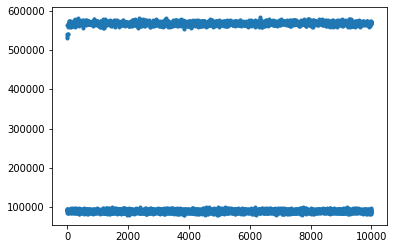

In [154]:
from scipy.spatial import distance

xtc_read=[] # xtc_read[NR][n_frame][:]
for NR in range(n_replicas):
    xtc_read.append(mda.coordinates.XTC.XTCReader(paths_traj[0] % NR))#'subtraj/subtraj1.xtc')
#print(xtc_read)



#print(len(xtc_read))

dx_single=[] # single replica
dx_couple=[] # same replica
dx=np.zeros((n_replicas,n_replicas))

start=time.time()
for n_frame in range(len(xtc_read[0])-1):
    NR1=23
    NR2=23
    dx_single.append(np.sum(np.abs(+xtc_read[NR1][n_frame+1][:]-xtc_read[NR2][n_frame][:])))

for n_frame in range(10):
    dx=np.zeros(n_replicas)
    for NR in range(n_replicas):
        dx[NR]=np.sum(np.abs(+xtc_read[NR][n_frame+1][:]-xtc_read[NR][n_frame][:]))
    
    dx_couple.append(dx)
    #dx_single.append(distance.cdist(xtc_read[[n_frame+1][:],xtc_read[n_frame][:],"sqeuclidean"))

    #cost=distance.cdist(xtc_read[n_frame+1][:],xtc_read[n_frame][:],"sqeuclidean")
    #print(cost)
    
    #for NR1 in range(n_replicas):
    #    for NR2 in range(n_replicas):
    #        dx[NR1,NR2]=np.sum(np.abs(+xtc_read[NR1][n_frame+1][:]-xtc_read[NR2][n_frame][:]))
    #if (n_frame%100)==0:
    #    print(n_frame)
    
    #print(dx)

    #for NR in range(n_replicas):
        
    #v1=+xtc_read[n_frame][:]
    #v2=+xtc_read[n_frame+1][:]

    #dx=v2-v1
    #print(dx)
print('time: ',time.time()-start)
plt.plot(dx_single,'.')
#print(dx[0])




### other

[ 84755.76   89857.4   534218.4   ...  90600.68   84979.125 568219.1  ]


3387

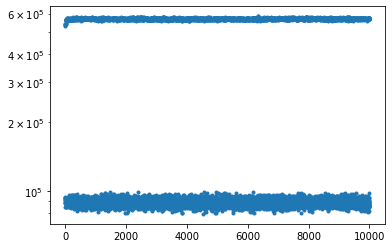

In [130]:
dx_single=np.array(dx_single)
plt.plot(dx_single,'.')
print(dx_single)
#plt.xlim([500,800])
plt.yscale('log')
len(dx_single[dx_single>2e5])
#len(np.where(dx_single>200000))

to speed up: just by reading coordinates, it takes 30 frames/sec., so you can define a subtrajectory with only MW atoms, by using gromacs command gmx trjconv or mda.Writer

In [23]:
print(path_ref)
print(paths_traj)

/net/sbp/srnas2/tfrahlki/Simulations/AAAA_TREMD/Production/AAAA/reference.pdb
['/net/sbp/srnas2/tfrahlki/Simulations/AAAA_TREMD/Production/AAAA/traj_comp%s.xtc', '/net/sbp/srnas2/tfrahlki/Simulations/AAAA_TREMD/Production/AAAA/traj_comp%s.part0002.xtc', '/net/sbp/srnas2/tfrahlki/Simulations/AAAA_TREMD/Production/AAAA/traj_comp%s.part0003.xtc', '/net/sbp/srnas2/tfrahlki/Simulations/AAAA_TREMD/Production/AAAA/traj_comp%s.part0004.xtc', '/net/sbp/srnas2/tfrahlki/Simulations/AAAA_TREMD/Production/AAAA/traj_comp%s.part0005.xtc', '/net/sbp/srnas2/tfrahlki/Simulations/AAAA_TREMD/Production/AAAA/traj_comp%s.part0006.xtc', '/net/sbp/srnas2/tfrahlki/Simulations/AAAA_TREMD/Production/AAAA/traj_comp%s.part0007.xtc', '/net/sbp/srnas2/tfrahlki/Simulations/AAAA_TREMD/Production/AAAA/traj_comp%s.part0008.xtc', '/net/sbp/srnas2/tfrahlki/Simulations/AAAA_TREMD/Production/AAAA/traj_comp%s.part0009.xtc', '/net/sbp/srnas2/tfrahlki/Simulations/AAAA_TREMD/Production/AAAA/traj_comp%s.part0010.xtc', '/net/sbp/

In [16]:
@numba.jit
def demux(paths_traj,path_ref,max_step,n_replicas,start_frame):
    permutations=[]
    speed=[]
    
    permutations.append(np.arange(n_replicas))

    univ=mda.Universe(path_ref,paths_traj[0] % 0) # replica 0, just to know the n. of atoms
    ncoord=np.shape(univ.select_atoms("name MW").positions.flatten())[0] # select_atoms("name MW") or atoms
    print('3N = (with N n. of atoms): ',ncoord)

    # initialization of x
    x=np.zeros((n_replicas,ncoord))

    univ=[]
    for NR in range(0,n_replicas):
        univ.append(mda.Universe(path_ref,paths_traj[0] % NR))
        univ[NR].trajectory[start_frame]
        x[NR,:]=univ[NR].select_atoms("name MW").positions.flatten()

    for i in range(len(paths_traj)): # index of subtrajectory
        univ=[]
        for NR in range(0,n_replicas):
            print(NR)
            # the first time, it is useless
            univ.append(mda.Universe(path_ref,paths_traj[0] % NR))
            #univ.append(mda.Universe(path_ref,paths_traj[0] % NR).select_atoms("name MW"))
            print(univ)
        nframes=len(univ[0].trajectory)
        
        start=time.time()
        for j in range(start_frame+1,nframes):#len(10):#,len(univ)): # for on the frames


            x_new=np.zeros((n_replicas,ncoord))
            dx=np.zeros((n_replicas,n_replicas,ncoord))

            for NR2 in range(n_replicas):
                univ[NR2].trajectory[j]
                x_new[NR2,:]=univ[NR2].atoms.positions.flatten()
                #x_new[NR2,:]=univ[NR2].trajectory[j].positions.flatten()
                for NR in range(n_replicas):
                   dx[NR2,NR,:]=np.abs(x[NR,:]-x_new[NR2,:])
                
            x=x_new

            diff1=np.mean(dx,axis=2)
            # you can also compute the average removing the let's say 20% largest distances
            # or compute distances only for atoms in the bulk
        #print(diff1)

            ##i0,i1,i2=np.where(dx<max_step)
            ##diff2=np.histogram2d(i0,i1,bins=np.arange(n_replicas+1))[0]
        #print(diff2)

            (rows,cols1)=linear_sum_assignment(diff1)
            #cols1=np.argmin(diff1,axis=1)
            
            #cols1=np.zeros(n_replicas)
            #for iter in range(n_replicas):
            #    cols1[iter]=np.argmin(diff1[iter,:])

            
            ##(rows,cols2)=linear_sum_assignment(1/diff2)
            #print(1/diff2)
            if (j%100)==0:
                #print(j)
                #print(diff1)
            ##    print(permutations[-1])
            ##    print(cols2)
                times=time.time()-start
                #print(time.time()-start)
                speed.append(j/times)
                print('speed (n. frames/sec.): ',speed[-1])
            #if np.array_equal(cols1,cols2):
            permutations.append(permutations[-1][cols1])
            #else:
            #    print('error')
            #    break
    
    
    return permutations,speed


In [15]:
permutations=[]
permutations.append(np.arange(n_replicas))

# for n_seq in [0]:#range(len(Sequences)):
n_seq=0

Sequence=Sequences[n_seq]
curr_dir='/net/sbp/srnas2/tfrahlki/Simulations/%s_TREMD/Production/%s' % (Sequence,Sequence)
print('tetramer: ',Sequence)
print(curr_dir)

univ=mda.Universe(curr_dir+'/reference.pdb',curr_dir+'/traj_comp0.part%s.xtc' % l[0])
ncoord=np.shape(univ.atoms.positions.flatten())[0]
print('3N = (with N n. of atoms): ',ncoord)

# initialization of x
x=np.zeros((n_replicas,ncoord))

for NR in range(n_replicas):
    exec('univ'+str(NR)+"=mda.Universe(curr_dir+'/reference.pdb',curr_dir+'/traj_comp%s.part%s.xtc' % (NR, l[0]))")
    exec('univ'+str(NR)+".trajectory[0]")
    exec('x[NR,:]=univ'+str(NR)+'.atoms.positions.flatten()') 



# for i in range(js[n_seq]):
i=0 # index of subtrajectory

for NR in range(n_replicas):
    #path=curr_dir+'/traj_comp%s.part%s.xtc' % (NR, l[i])
    exec('univ'+str(NR)+"=mda.Universe(curr_dir+'/reference.pdb',curr_dir+'/traj_comp%s.part%s.xtc' % (NR, l[i]))")

for j in range(1,10):#,len(univ)): # for on the frames
    print('frame n. ',j)
#j=5 # frame index

    x_new=np.zeros((n_replicas,ncoord))
    dx=np.zeros((n_replicas,n_replicas,ncoord))

    for NR2 in range(n_replicas):
        exec('univ'+str(NR)+".trajectory[j]")

##x=np.zeros((n_replicas,ncoord))
##x_new=np.zeros((n_replicas,ncoord))
##dx=np.zeros((n_replicas,n_replicas,ncoord))

##for NR in range(n_replicas):
##    exec('x[NR,:]=univ'+str(NR)+'.atoms.positions.flatten()') 

##univ.trajectory[j+1]
##for NR in range(n_replicas):
##    exec('univ'+str(NR)+'.trajectory[j+1]')

##for NR in range(n_replicas):
        exec('x_new[NR2,:]=univ'+str(NR)+'.atoms.positions.flatten()')
        for NR in range(n_replicas):
            dx[NR2,NR,:]=np.abs(x[NR,:]-x_new[NR2,:])
            
    #print(dx)
#dx=np.abs(x-x_new)#distance.cdist(x,x_new,'minkowski',p=1)

    x=x_new

    diff1=np.mean(dx,axis=2)
    # you can also compute the average removing the let's say 20% largest distances
    #print(diff1)

    i0,i1,i2=np.where(dx<5)
    diff2=np.histogram2d(i0,i1,bins=np.arange(n_replicas+1))[0]
    #print(diff2)

    (rows,cols1)=linear_sum_assignment(diff1)
    (rows,cols2)=linear_sum_assignment(1/diff2)
    print(1/diff2)
    print(permutations[-1])
    print(cols2)
    if np.array_equal(cols1,cols2):
        permutations.append(permutations[-1][cols2])
    else:
        print('error')

tetramer:  AAAA
/net/sbp/srnas2/tfrahlki/Simulations/AAAA_TREMD/Production/AAAA


/u/i/igilardo/.local/lib/python3.6/site-packages/MDAnalysis/topology/PDBParser.py:334: UserWarning: Unknown element VS found for some atoms. These have been given an empty element record. If needed they can be guessed using MDAnalysis.topology.guessers.
  warnings.warn(wmsg)
/u/i/igilardo/.local/lib/python3.6/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: VS
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))
/u/i/igilardo/.local/lib/python3.6/site-packages/MDAnalysis/coordinates/XDR.py:232: UserWarning: Couldn't save offsets because: [Errno 13] Permission denied: '/net/sbp/srnas2/tfrahlki/Simulations/AAAA_TREMD/Production/AAAA/.traj_comp0.part0002.xtc_offsets.npz'
  warnings.warn("Couldn't save offsets because: {}".format(e))


3N = (with N n. of atoms):  37086


/u/i/igilardo/.local/lib/python3.6/site-packages/MDAnalysis/coordinates/XDR.py:232: UserWarning: Couldn't save offsets because: [Errno 13] Permission denied: '/net/sbp/srnas2/tfrahlki/Simulations/AAAA_TREMD/Production/AAAA/.traj_comp1.part0002.xtc_offsets.npz'
  warnings.warn("Couldn't save offsets because: {}".format(e))
/u/i/igilardo/.local/lib/python3.6/site-packages/MDAnalysis/coordinates/XDR.py:232: UserWarning: Couldn't save offsets because: [Errno 13] Permission denied: '/net/sbp/srnas2/tfrahlki/Simulations/AAAA_TREMD/Production/AAAA/.traj_comp2.part0002.xtc_offsets.npz'
  warnings.warn("Couldn't save offsets because: {}".format(e))
/u/i/igilardo/.local/lib/python3.6/site-packages/MDAnalysis/coordinates/XDR.py:232: UserWarning: Couldn't save offsets because: [Errno 13] Permission denied: '/net/sbp/srnas2/tfrahlki/Simulations/AAAA_TREMD/Production/AAAA/.traj_comp3.part0002.xtc_offsets.npz'
  warnings.warn("Couldn't save offsets because: {}".format(e))
/u/i/igilardo/.local/lib/pyt

frame n.  1
[[1.27097102e-04 1.28024581e-04 1.32961042e-04 1.28254457e-04
  1.24564026e-04 1.26278571e-04 1.29282482e-04 1.30838676e-04
  1.26008065e-04 1.30072841e-04 1.31596263e-04 1.30039012e-04
  1.28419160e-04 1.30395097e-04 1.26486213e-04 1.26406270e-04
  1.26198889e-04 1.24641655e-04 1.27959053e-04 1.28982329e-04
  1.27942682e-04 1.31648236e-04 1.27518490e-04 2.82095405e-05]
 [1.27097102e-04 1.28024581e-04 1.32961042e-04 1.28254457e-04
  1.24564026e-04 1.26278571e-04 1.29282482e-04 1.30838676e-04
  1.26008065e-04 1.30072841e-04 1.31596263e-04 1.30039012e-04
  1.28419160e-04 1.30395097e-04 1.26486213e-04 1.26406270e-04
  1.26198889e-04 1.24641655e-04 1.27959053e-04 1.28982329e-04
  1.27942682e-04 1.31648236e-04 1.27518490e-04 2.82095405e-05]
 [1.27097102e-04 1.28024581e-04 1.32961042e-04 1.28254457e-04
  1.24564026e-04 1.26278571e-04 1.29282482e-04 1.30838676e-04
  1.26008065e-04 1.30072841e-04 1.31596263e-04 1.30039012e-04
  1.28419160e-04 1.30395097e-04 1.26486213e-04 1.2640627

In [15]:
def demux(n_replicas,paths_traj,start_frame):#,N=100):#,userdoc,N=100): # if_local

    permutations=[]
    times=[]
    permutations.append(np.arange(n_replicas))

    start=time.time()

    for n_subtraj in range(len(paths_traj)):
        
        xtc_read=[] # xtc_read[NR][n_frame][:]
        for NR in range(n_replicas):
            xtc_read.append(mda.coordinates.XTC.XTCReader(paths_traj[n_subtraj] % NR))
                
        n_frame0=start_frame
        if n_subtraj==0:
            x=[]
            for NR in range(n_replicas):
                x.append(xtc_read[NR][start_frame][:].flatten())
            x=np.array(x)
            n_frame0=start_frame+1 # if already initialised, start from next frame
        print(x)

        len_subtraj=len(xtc_read[0])
        for n_frame in range(n_frame0,len_subtraj):
            x_new=[]
            for NR in range(n_replicas):
                x_new.append(xtc_read[NR][n_frame][:].flatten())
            x_new=np.array(x_new)
            print(x_new)
        
    return x,x_new
            
        #    diff = distance.cdist(x,x_new,"sqeuclidean")
        #    check=np.max((np.min(diff,axis=1)-np.partition(diff,1,axis=1)[:,1])/np.min(diff,axis=1))
        #    print(check)

        #    print(np.min(diff,axis=1)/1e6)
        #    print(np.partition(diff,1,axis=1)[:,1]/1e6)
        #    print(diff/1e6)

        #    (rows,cols)=linear_sum_assignment(diff)
            # or equivalently:
            #cols=np.argmin(diff,axis=1)
            #print(cols)

        #    permutations.append(permutations[-1][cols])
        #    print(permutations[-1][cols])

        #    if (n_frame%N)==0:
        #        times.append(time.time()-start)
                #print(times[-1])

In [16]:
demux(n_replicas,paths_traj,start_frame)

/u/i/igilardo/.local/lib/python3.6/site-packages/MDAnalysis/coordinates/XDR.py:232: UserWarning: Couldn't save offsets because: [Errno 13] Permission denied: '/net/sbp/srnas2/tfrahlki/Simulations/CAAU_TREMD/Production/CAAU/.traj_comp0.xtc_offsets.npz'
  warnings.warn("Couldn't save offsets because: {}".format(e))
/u/i/igilardo/.local/lib/python3.6/site-packages/MDAnalysis/coordinates/XDR.py:232: UserWarning: Couldn't save offsets because: [Errno 13] Permission denied: '/net/sbp/srnas2/tfrahlki/Simulations/CAAU_TREMD/Production/CAAU/.traj_comp1.xtc_offsets.npz'
  warnings.warn("Couldn't save offsets because: {}".format(e))
/u/i/igilardo/.local/lib/python3.6/site-packages/MDAnalysis/coordinates/XDR.py:232: UserWarning: Couldn't save offsets because: [Errno 13] Permission denied: '/net/sbp/srnas2/tfrahlki/Simulations/CAAU_TREMD/Production/CAAU/.traj_comp2.xtc_offsets.npz'
  warnings.warn("Couldn't save offsets because: {}".format(e))
/u/i/igilardo/.local/lib/python3.6/site-packages/MDAnal

[[42.03      39.620003  12.290001  ... 46.340004  38.7       31.390001 ]
 [39.700005  35.690002  12.110001  ... 49.710003  39.08      31.380003 ]
 [36.83      38.530003  12.45      ... 45.5       34.910004  33.760002 ]
 ...
 [46.270004  22.69      21.27      ... 24.910002  30.16       7.6200004]
 [45.92      26.04      25.28      ... 23.850002  27.630003  10.650001 ]
 [43.41      28.130001  25.760002  ... 38.750004  44.14       2.38     ]]
[[41.9       38.690002  10.550001  ... 45.880005  39.15      31.760002 ]
 [40.2       36.280003  11.730001  ... 49.910004  39.280003  30.800001 ]
 [37.000004  38.28      11.910001  ... 46.020004  36.020004  33.36     ]
 ...
 [47.1       22.390001  21.35      ... 26.29      30.340002   8.940001 ]
 [46.300003  25.62      24.34      ... 23.430002  27.400002   9.410001 ]
 [43.230003  27.470001  25.77      ... 37.350002  45.33       2.8400002]]
[[42.03     38.4      11.71     ... 45.56     39.23     31.760002]
 [40.29     35.43     11.170001 ... 49.14    

In [13]:
from scipy.spatial import distance

print(x.shape)
print(x_new.shape)

NameError: name 'x' is not defined

## output data

In [11]:
Seqs=['AAAA','CAAU','CCCC']
n_seq=1

demuxed_temp=np.array(pandas.read_csv('demuxing%s/demuxed' % Seqs[n_seq],header=None))
demuxed_temp=demuxed_temp.astype(int)

time=pandas.read_csv('demuxing%s/time' % Seqs[n_seq],header=None)
check=pandas.read_csv('demuxing%s/check' % Seqs[n_seq],header=None)
N=100 # step to save time (value from run_demux.py)

In [12]:
n_replicas=len(demuxed_temp.T)
n_replicas

24

In [13]:
replicas=[]

a0=np.arange(n_replicas)
for i in range(len(demuxed_temp)):
    replicas.append(a0[demuxed_temp[i,:]])

replicas=np.array(replicas)

replica at temperature 300K is:  [6 6 6 ... 8 1 1]


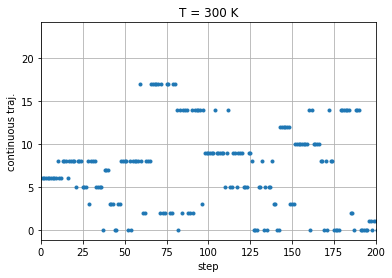

In [15]:
print('replica at temperature 300K is: ',replicas[:,6])
plt.plot(replicas[:,6],'.')
plt.xlim([0,200])
plt.title('T = 300 K')
plt.ylabel('continuous traj.')
plt.xlabel('step')
plt.grid()
plt.show()

total time (hours):  15.295899693436093
speed (frames/sec.):  12.383492992435794
expected time (hours):  22.431294461704198
total n. of frames:  682000


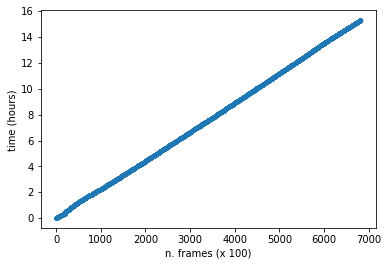

In [16]:
plt.plot(time/3600,'.')
plt.xlabel('n. frames (x %s)' % N)
plt.ylabel('time (hours) ')


nframe=len(time[0])-1# last frame, or nframe=500
print('total time (hours): ',time[0][nframe]/3600)
speed=N*nframe/time[0][nframe]
print('speed (frames/sec.): ',speed)
print('expected time (hours): ',1e6/speed/3600)

print('total n. of frames: ',len(demuxed_temp))

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]


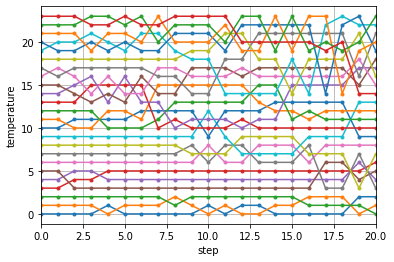

In [17]:
#print(demuxed)
n_replica=0

print(demuxed_temp[n_replica])

#plt.plot(demuxed[n_replica][:],'.-')
plt.plot(demuxed_temp,'.-')
plt.xlim([0,20])#1000,1200])
plt.ylabel('temperature')
plt.xlabel('step')
plt.grid()


In [18]:
print(np.max(check))
print(check)

0   -4.052659
dtype: float64
               0
0      -4.504170
1      -4.696897
2      -4.451374
3      -4.562277
4      -4.685623
...          ...
681994 -5.177853
681995 -4.846754
681996 -4.776118
681997 -4.747599
681998 -4.774633

[681999 rows x 1 columns]


[[42192 41954 41659 41456 41799 41961 42092 41954 41541 41752 41931 41952
  41838 41774 41680 42008 41726 41661 41908 41802 41820 41830 41716 41994]]


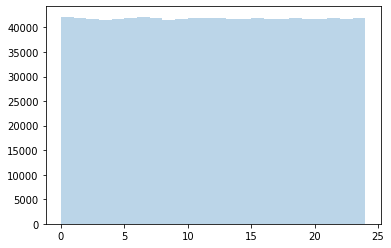

In [31]:
hists=[]
plt.figure()
for n_replica in range(1):
    counts,bins=np.histogram(demuxed[n_replica][:],bins=np.arange(0,25))
    plt.hist(bins[:-1],bins,weights=counts,alpha=0.3)
    hists.append(counts)

print(np.array(hists))
